# Предобработка данных

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Загрузим датасет Flickr 30:

In [0]:
!wget http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k-images.tar

--2020-02-20 14:17:09--  http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k-images.tar
Resolving shannon.cs.illinois.edu (shannon.cs.illinois.edu)... 18.220.149.166
Connecting to shannon.cs.illinois.edu (shannon.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4440780800 (4.1G) [application/x-tar]
Saving to: ‘flickr30k-images.tar’

flickr30k-images.ta 100%[===================>]   4.14G  26.9MB/s    in 84s     

2020-02-20 14:18:34 (50.2 MB/s) - ‘flickr30k-images.tar’ saved [4440780800/4440780800]



In [0]:
%%time
!tar -xf '/content/flickr30k-images.tar'

CPU times: user 343 ms, sys: 46.3 ms, total: 389 ms
Wall time: 1min 45s


In [0]:
from torchvision import transforms, datasets
import os
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import random

Сохраним путь до папки с изображениями:

In [0]:
image_dir = '/content/flickr30k-images' 

image_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

## Подготовка captions

Изначально я скачала датасет Flickr 30 на Kaggle, но архив с изображениями оттуда весил 8 Гб вместо 4 Гб, поэтому я нашла его в другом месте. Но вот файл с аннотациями results.csv оставила. Правда в нем был пропущен разделитель в одной строке (вроде бы № 19999), поэтому я его добавила, так получился файл results_new.csv (прилагается). В нем содержится список имен файлов картинок и соответствующие им заголовки. Одной картинке соответствует 5 строк из файла. 

In [0]:
results = pd.read_csv("/content/drive/My Drive/Image Captioning/Flickr30/results_new.csv", sep='|', index_col=None)

In [0]:
results.head(15)

image_name  ...                                            comment
0   1000092795.jpg  ...   Two young guys with shaggy hair look at their...
1   1000092795.jpg  ...   Two young , White males are outside near many...
2   1000092795.jpg  ...   Two men in green shirts are standing in a yard .
3   1000092795.jpg  ...       A man in a blue shirt standing in a garden .
4   1000092795.jpg  ...            Two friends enjoy time spent together .
5     10002456.jpg  ...   Several men in hard hats are operating a gian...
6     10002456.jpg  ...   Workers look down from up above on a piece of...
7     10002456.jpg  ...   Two men working on a machine wearing hard hats .
8     10002456.jpg  ...              Four men on top of a tall structure .
9     10002456.jpg  ...                         Three men on a large rig .
10  1000268201.jpg  ...   A child in a pink dress is climbing up a set ...
11  1000268201.jpg  ...   A little girl in a pink dress going into a wo...
12  1000268201.jpg  ...   A little girl climbing the stairs to her play...
13  1000268201.jpg  ...    A little girl climbing into a wooden playhouse 
14  1000268201.jpg  ...              A girl going into a wooden building .

[15 rows x 3 columns]

In [0]:
# Переименуем колонки, чтобы убрать пробелы в начале имени
results.columns = ['image_name', 'comment_number', 'comment']

In [0]:
# Приведем строки к нижнему регистру
results.comment = results.comment.str.lower()

In [0]:
# Объединим все заголовки для одной картинки в один массив
results = results.groupby('image_name')['comment'].apply(list).reset_index(name='captions')

In [0]:
results

image_name                                           captions
0      1000092795.jpg  [ two young guys with shaggy hair look at thei...
1        10002456.jpg  [ several men in hard hats are operating a gia...
2      1000268201.jpg  [ a child in a pink dress is climbing up a set...
3      1000344755.jpg  [ someone in a blue shirt and hat is standing ...
4      1000366164.jpg  [ two men , one in a gray shirt , one in a bla...
...               ...                                                ...
31778   997338199.jpg  [ woman writing on a pad in room with gold , d...
31779   997722733.jpg  [ a person in a red shirt climbing up a rock f...
31780   997876722.jpg  [ two male construction workers are working on...
31781    99804383.jpg  [ an older busker in glasses plays an eastern ...
31782   998845445.jpg  [ a man in shorts and a hawaiian shirt leans o...

[31783 rows x 2 columns]

In [0]:
results.image_name[0]

'1000092795.jpg'

In [0]:
results.captions[0]

[' two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' two young , white males are outside near many bushes .',
 ' two men in green shirts are standing in a yard .',
 ' a man in a blue shirt standing in a garden .',
 ' two friends enjoy time spent together .']

In [0]:
len(results)

31783

Разделим датафрейм на train и val:

In [0]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(results, test_size=1024)

In [0]:
val_set.index = range(len(val_set))

In [0]:
val_set

image_name                                           captions
0     3655176735.jpg  [ an older woman appears to read from a childr...
1     7669392800.jpg  [ numerous bicyclists wearing bicyclist appare...
2     4546029322.jpg  [ in this picture we see multiple people cross...
3      120764850.jpg  [ a baby on the floor laughing at an older ano...
4     2912210904.jpg  [ a man loads trees onto a cart on the side of...
...              ...                                                ...
1019  6813684611.jpg  [ three people are playing music ; two with vi...
1020  3288203502.jpg  [ redheaded woman holding clear plastic over p...
1021  6221289833.jpg  [ a boy wearing a white and green athletic uni...
1022   241345323.jpg  [ sooners football player number 50 plays in a...
1023  5392145976.jpg  [ a woman rollerblader with knee and elbow pad...

[1024 rows x 2 columns]

In [0]:
train_set.index = range(len(train_set))

In [0]:
train_set

image_name                                           captions
0      2251277216.jpg  [ various people are walking along a path towa...
1       263216826.jpg  [ a man and a woman in an orange shirt are sit...
2      3627929314.jpg  [ a little boy sitting on the ground looking u...
3      3019986034.jpg  [ a woman in a plaid skirt is playing a violin...
4      4508999124.jpg  [ a small boy with a blue and yellow backpack ...
...               ...                                                ...
30754  7108301125.jpg  [ several women are playing some sort of sport...
30755  2380519648.jpg  [ a man with a cap and not wearing shirt is la...
30756   128396207.jpg  [ a bike rider with khaki green shorts , a blu...
30757   361831875.jpg  [ a person in a green coat looks upwards while...
30758  4806000438.jpg  [ men wearing red and white stripe shirts and ...

[30759 rows x 2 columns]

Посчитаем число вхождений каждого слова из заголовков для обучения:

In [0]:
from collections import Counter
token_counts = Counter()

for cap in train_set.captions:
    for line in cap:
        token_counts.update(line.split())

In [0]:
token_counts.most_common(10)

[('a', 263031),
 ('.', 146139),
 ('in', 80901),
 ('the', 61002),
 ('on', 44158),
 ('and', 42866),
 ('man', 41190),
 ('is', 39806),
 ('of', 37532),
 ('with', 35041)]

Загрузим предобученные эмбеддинги:

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip 

--2020-02-20 14:20:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  26.4MB/s    in 52s     

2020-02-20 14:21:32 (27.8 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip '/content/crawl-300d-2M.vec.zip' 

Archive:  /content/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
import gensim

In [0]:
%%time
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(fname='/content/crawl-300d-2M.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 9min 29s, sys: 7.54 s, total: 9min 36s
Wall time: 9min 33s


Составим словарь токенов:

In [0]:
min_count = 5
tokens = [token for token, num in token_counts.items() if (token in w2v_model and num>=min_count)]

Добавим в словарь специальные символы:

In [0]:
UNK, PAD, BOS, EOS = "UNK", "PAD", "<bos>", "<eos>"
tokens = [PAD, BOS, EOS, UNK] + tokens

In [0]:
len(tokens)

7628

In [0]:
n_tokens = len(tokens)

Построим словарь для перевода токенов в индексы:

In [0]:
token_to_id = {t:i for i, t in enumerate(tokens)}

In [0]:
UNK_IDX, PAD_IDX = token_to_id["UNK"], token_to_id["PAD"]
BOS_IDX, EOS_IDX = token_to_id["<bos>"], token_to_id["<eos>"]

Сформируем матрицу для загрузки в слой nn.Embedding:

In [0]:
numpy_embeddings = np.zeros(shape=[len(tokens), 300],dtype=np.float32)

for word in tokens:
    if word in w2v_model:
        vector = w2v_model.get_vector(word)
        index  = token_to_id[word]
        numpy_embeddings[index] = vector
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([7628, 300])

## Формирование датасетов для обучения и валидации

In [0]:
def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        max_len: if specified, 
    """

    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len+2), np.int32(PAD_IDX))
    for i,seq in enumerate(sequences):
        row_ix = [BOS_IDX] + [token_to_id.get(word, UNK_IDX) for word in seq[:max_len]] + [EOS_IDX]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
# batch generator
from random import choice

def generate_batch(dataset, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_index = np.random.randint(0, len(dataset), size=batch_size)
    
    batch_images, batch_captions = None, []

    for ind in random_index:

        image, captions = dataset[ind]

        if batch_images is None:
            batch_images = image.unsqueeze(0)
        else:
            batch_images = torch.cat((batch_images, image.unsqueeze(0)), 0)

        caption = choice(captions)

        batch_captions.append(caption)

    batch_captions = as_matrix(batch_captions, max_caption_len)
    
    return batch_images, torch.tensor(batch_captions, dtype=torch.int64)

In [0]:
class FlickrDataset(Dataset):
    """Flickr30 dataset."""

    def __init__(self, data_frame, root_dir, image_transform):
        """
        Args:
            data_frame : Dataframe with annotations.
            root_dir : Directory with all the images.
            transform : Optional transform to be applied on a sample.
        """
        self.data_frame = data_frame 
        self.root_dir = root_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        image_name = os.path.join(self.root_dir,
                                self.data_frame.image_name[idx])
        image = plt.imread(image_name)
        image = np.array(Image.fromarray(image).resize((256, 256))).astype('float32') / 255.
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        if self.image_transform is not None:
            image = self.image_transform(image)

        captions = self.data_frame.captions[idx]

        return image, captions

    def show_sample(self, idx):

        image_name = os.path.join(self.root_dir,
                                self.data_frame.image_name[idx])
        image = plt.imread(image_name)
        image = np.array(Image.fromarray(image).resize((299, 299))).astype('float32') / 255.

        captions = self.data_frame.captions[idx]
        captions = np.array(captions)

        plt.imshow(image)
        print(captions)

### Train dataset

In [0]:
train_dataset = FlickrDataset(train_set, image_dir, image_transform)

In [0]:
len(train_dataset)

30759

Посмотрим на примеры из датасета для обучения:

[' various people are walking along a path towards a fenced-in area that is surrounded by small buildings .'
 ' people running on a sidewalk in the middle of a grassy area .'
 ' people running and walking in and out of a small farm town .'
 ' several couples running down the road to a farm house .'
 ' a woman runs along the sidewalk .']


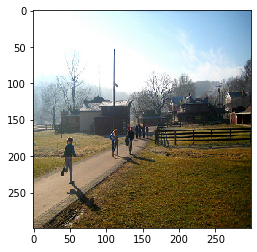

In [0]:
train_dataset.show_sample(0)

[' crowded street with a man holding a subway sign pointing customers to a subway sandwich shop .'
 ' a man dressed in blue , holding a subway sandwich sign on the sidewalk .'
 ' a man in a blue shirt and blue jeans standing behind a subway sign .'
 ' a man in all bright blue against a subway sign in new york city .'
 ' man holding a sign promoting subway restaurant .']


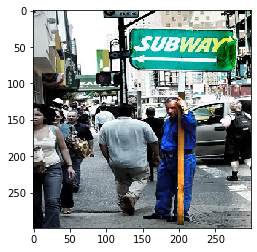

In [0]:
train_dataset.show_sample(12345)

Протестируем генерацию батча:

In [0]:
# max_caption_len без учета спец символов для начала и конца предложения
batch = generate_batch(train_dataset, 3, max_caption_len=10)

In [0]:
batch[1]

tensor([[   1,    9,  412,    5,   45,   35,   29, 1611,   22,    9,  409,    2],
        [   1,  180,   15,   42,  515,  421,   56,  422,   27, 1201,  208,    2],
        [   1,   25,  249,   15,   87, 2255, 2857,   56,  619,  106,   24,    2]])

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 3, 256, 256]), torch.Size([3, 12]))

In [0]:
batch = generate_batch(train_dataset, 3)

In [0]:
batch[1]

tensor([[   1,    9,   63,  122,   98,    9, 4665,  137,  251,   30,  208,   25,
           91,   63,  122,   37,  807,   20,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    9,   41,   24,    9,  139,  110,   48, 4945,   76,   48,   25,
          303,  203,    9,  155,   27,  133, 1525,   20,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   61,  108,   68,   87,  100,  170,   56,    9,   94,  111,   29,
           94,   29,  520,  116,   87,    9, 3843,  112,   25,   91,   74,    9,
         2489,   29,    9, 7556, 1645,   44,   87,    9, 2447,   20,    2]])

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 3, 256, 256]), torch.Size([3, 35]))

### Validation dataset

In [0]:
# Переводит массив индексов в строку/массив с токенами (до первого символа конца строки)
def translate(list_ind, to_str=True):
  
  if EOS_IDX in list_ind:
    max_ind = list_ind.index(EOS_IDX)
  else:
    max_ind = len(list_ind)

  if to_str:
    return (' ').join([tokens[ind] for ind in list_ind[:max_ind]])
  else:
    return [tokens[ind] for ind in list_ind[:max_ind]]

In [0]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [0]:
val_dataset = FlickrDataset(val_set, image_dir, image_transform)

In [0]:
len(val_dataset)

1024

[' swimming instructors teaching young girls how to float in a pool .'
 ' man in black swimsuit plays in pool with three young children .'
 ' two men in wetsuits supervise children as they learn to swim .'
 ' swimming instructors show young girls how to float .'
 ' a group of children learning to swim .']


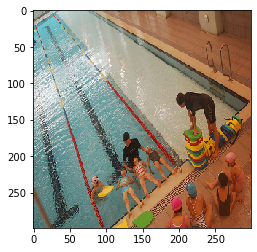

In [0]:
# Fixed example
val_dataset.show_sample(992)

In [0]:
batch_size_val = 32

In [0]:
val_size = len(val_dataset) // batch_size_val * batch_size_val

In [0]:
val_size

1024

In [0]:
# Для расчета bleu
references = []
for cap in val_set.captions[:val_size]:
  new_cap = []
  for str_cap in cap:
    new_cap.append(list(str_cap.split()))
  references.append(new_cap)

In [0]:
references[0]

[['an',
  'older',
  'woman',
  'appears',
  'to',
  'read',
  'from',
  'a',
  'children',
  "'s",
  'book',
  'in',
  'an',
  'indoor',
  'setting',
  ',',
  'while',
  'a',
  'seated',
  'gentleman',
  'in',
  'a',
  'service',
  'uniform',
  'looks',
  'on',
  '.'],
 ['a',
  'woman',
  'with',
  'short',
  'black',
  'hair',
  'and',
  'a',
  'colorful',
  'necklace',
  'reads',
  'a',
  'children',
  "'s",
  'illustration',
  'book',
  '.'],
 ['a',
  'woman',
  'with',
  'a',
  'white',
  'shirt',
  'holding',
  'a',
  'children',
  'book',
  '.'],
 ['a', 'woman', 'reading', 'a', 'children', "'s", 'book', '.'],
 ['a', 'lady', 'reading', 'a', 'story', 'book', '.']]

In [0]:
# batch generator
def generate_batch_val(dataset, indx, batch_size, max_caption_len=None):
    
    batch_images, batch_captions = None, []

    for ind in range(indx, indx+batch_size):

        image, captions = dataset[ind]

        if batch_images is None:
            batch_images = image.unsqueeze(0)
        else:
            batch_images = torch.cat((batch_images, image.unsqueeze(0)), 0)

        caption = choice(captions)

        batch_captions.append(caption)

    batch_captions = as_matrix(batch_captions, max_caption_len)
    
    return batch_images, torch.tensor(batch_captions, dtype=torch.int64)
    

In [0]:
def evaluate(model, criterion, max_len=None, val_size=len(val_dataset), batch_size=batch_size_val):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size

    random_ind = random.randint(0, val_size-1)
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            image_vectors, captions_ix = generate_batch_val(val_dataset, i, batch_size) 
            
            image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

            captions_ix_next = captions_ix[:, 1:].contiguous()
        
            outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=0.)

            loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
            
            epoch_loss += loss.item()

            outputs_max = outputs.argmax(-1)
            for out in outputs_max:
              hypotheses.append(translate(out.tolist(), to_str=False))

            if random_ind in range(i,i+batch_size):
              print('Random example:')
              print('\tTarget: {}'.format(translate(captions_ix_next[random_ind % batch_size].tolist())))
              print('\tOutput: {}'.format(translate(outputs.argmax(-1)[random_ind % batch_size].tolist())))

    print('Fixed example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))

    bleu = corpus_bleu(references, hypotheses)
        
    return epoch_loss / (val_size // batch_size), bleu*100

# Посторение нейросети

##Encoder

In [0]:
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self):
        super(Encoder, self).__init__()

        resnet = models.resnet101(pretrained=True) 

        # Удаляем пулинг и последний линейный слой
        # На выходе будем получать тензор (batch_size, 2048, 8, 8)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Добавляем свой пулинг для получения вектора (batch_size, 2048)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        # (batch_size, 2048, 8, 8)
        out = self.resnet(images)

        # (batch_size, 2048, 1, 1)  
        out_lin = self.adaptive_pool(out) 

        # (batch_size, 2048) 
        out_lin = out_lin.squeeze(2).squeeze(2) 

        return out, out_lin

    def fine_tune(self, fine_tune=False):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False

##Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, num_layers=1):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens

        # create embedding for input words
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=PAD_IDX) 
        self.drop = nn.Dropout(0.4) 
            
        # lstm
        self.lstm = nn.LSTMCell(emb_size, lstm_units, bias=True) 

        self.drop_2 = nn.Dropout(0.1)

        # линейный слой для получения логитов
        self.fc_2 = nn.Linear(lstm_units, n_tokens)

        self.init_weights()
        
    def forward(self, captions, encoder_outputs, hidden=None, cell=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """

        # (batch_size)
        captions = captions 
        
        # embedded : (batch_size x emb_dim)
        embedded = self.embed(captions) 
        lstm_in = self.drop(embedded)

        # hidden : (batch_size x hidden_dim)        
        hidden, cell = self.lstm(lstm_in, (hidden, cell))

        # (batch_size x n_tokens)
        prediction = self.fc_2(self.drop_2(hidden)) 

        return prediction, hidden, cell 

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.fc_2.bias.data.fill_(0)
        self.fc_2.weight.data.uniform_(-0.08, 0.08)       

##Model

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, encoder, decoder, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, num_layers=1):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.cnn_feature_size = cnn_feature_size

        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, image_vectors, captions_ix=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        batch_size = image_vectors.shape[0] 

        # (batch_size x 2048 x 8 x 8), (batch_size x 2048)
        image_att, image_emb = self.encoder(image_vectors)

        if captions_ix is None:
          max_len = 30
        else:
          max_len = captions_ix.shape[1]      
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.n_tokens).to(device)

        cell = torch.sigmoid(self.cnn_to_c0(image_emb)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_emb)) 
        
        #first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_outputs, hidden, cell = self.decoder(captions_input, image_att, hidden, cell)

            outputs[:, t, :] = lstm_outputs

            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
              captions_input = captions_ix[:, t] 
            else:
              captions_input = lstm_outputs.argmax(-1) 
        
        return outputs[:, 1:] 

    def sample(self, image_vectors, max_len=None, sample=True, st=1.):
        
        if max_len is None:
            max_len = 35

        batch_size = image_vectors.shape[0]

        # Генерируем подпись для одного изображения
        assert batch_size == 1

        image_att, image_emb = self.encoder(image_vectors)     
        
        #tensor to store decoder outputs
        sentence = []

        # Инициализируем h и c для слоя lstm
        cell = torch.sigmoid(self.cnn_to_c0(image_emb)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_emb))  
        
        # Первый раз на вход декодеру подаем символ начала строки <bos>
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device)  
        
        for t in range(1, max_len):

            lstm_outputs, hidden, cell = self.decoder(captions_input, image_att, hidden, cell)

            if sample:
                # Выбираем токен согласно полученному распределению вероятностей
                next_word_probs = F.softmax(lstm_outputs[0], dim=-1).data.cpu().numpy()
                next_word_probs = next_word_probs ** st / np.sum(next_word_probs ** st)
                next_word = np.random.choice(tokens, p=next_word_probs)
            else:
                # Берем токен с максимальной вероятностью
                next_word = tokens[lstm_outputs[0].data.cpu().numpy().argmax(-1)]

            if next_word == EOS:
                break

            sentence.append(next_word)

            captions_input[0] = token_to_id[next_word]
        
        return (' ').join(sentence)        

# Training

In [0]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
enc_nn = Encoder()
dec_nn = Decoder(n_tokens, 300, 512, 2048, 1)
network = CaptionNet(enc_nn, dec_nn, n_tokens, 300, 512, 2048, 1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
network = network.to(device)

In [0]:
max_epochs = 30000
batch_size = 32
every_epochs = 300
clip = 5

In [0]:
pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
pytorch_total_params

7678412

In [0]:
pytorch_total_params = sum(p.numel() for p in network.parameters())
pytorch_total_params

52466972

In [0]:
def plot_loss():

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,2)
    plt.title("Losses")
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.plot(np.argmin(val_losses), np.min(val_losses), marker="x", color="r", label="best val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()

    plt.subplot(1,2,1)
    plt.title("BLEU")
    plt.plot(bleu, label="val bleu")
    plt.plot(np.argmax(bleu), np.max(bleu), marker="x", color="b", label="best bleu")
    plt.xlabel("Epochs")
    plt.ylabel("BLEU")
    plt.legend()

    plt.show()

Epoch : 300
Train example :
	Target: a dog runs holding a yellow dog toy in fall , bench in the background .
	Output: a man is a a a shirt . . a UNK . . a . .
Random example:
	Target: a street performer playing banjo on a city street .
	Output: a man in a red shirt is is on a a .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a red shirt is is on a a .
Train loss    : 4.976445798873901
Val loss      : 5.569959670305252
Val bleu      : 8.87000133214325



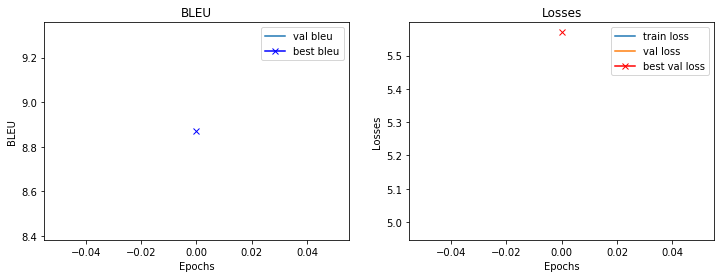

Epoch : 600
Train example :
	Target: a woman with blond-hair pulled in a ponytail steps out of an orange helicopter .
	Output: a man in a and on a red . . a a . . .
Random example:
	Target: three teenagers laying in a field and socializing with each other .
	Output: a man in a black shirt is walking on a street .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is walking on a street .
Train loss    : 4.2774454553922014
Val loss      : 5.837390571832657
Val bleu      : 8.717372680466362



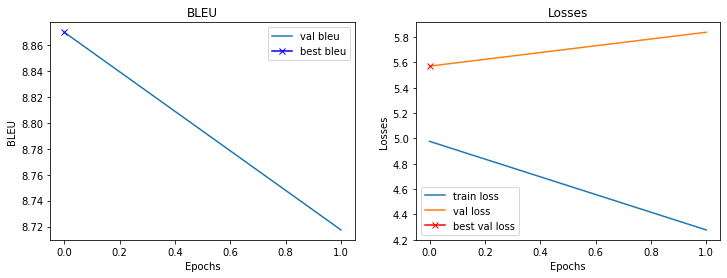

Epoch : 900
Train example :
	Target: a man with glasses playing a silver guitar .
	Output: a man is a is sitting on and .
Random example:
	Target: a man climbs up an artificial climbing wall .
	Output: a young boy in a red shirt is playing a a ball .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a red shirt is walking down a a hill .
Train loss    : 4.050437982877096
Val loss      : 6.020889148116112
Val bleu      : 12.245348655153247



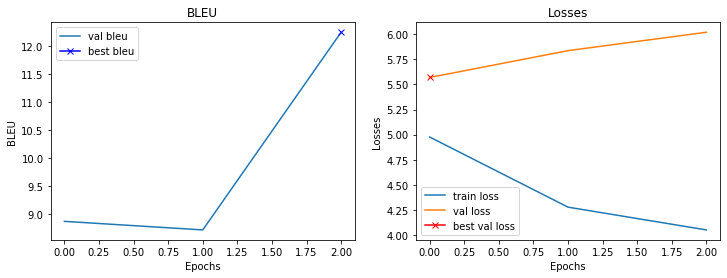

Epoch : 1200
Train example :
	Target: a boy pets a sleeping tiger .
	Output: a little in a red and .
Random example:
	Target: a little girl wearing a white and red outfit is taking a picture of an adult .
	Output: a group of people are standing in a city .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a red shirt is a a a a a boat .
Train loss    : 3.909198558330536
Val loss      : 6.136451542377472
Val bleu      : 11.69190783038775



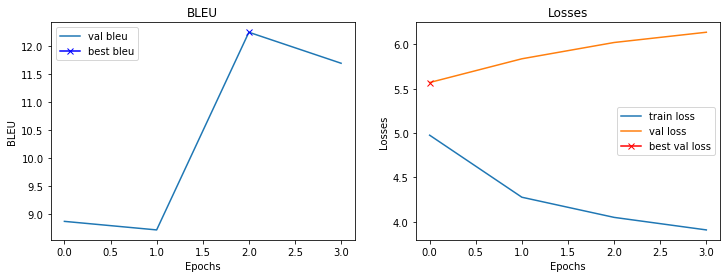

Epoch : 1500
Train example :
	Target: a race car zooms while onlookers watch .
	Output: a man is in through a of .
Random example:
	Target: 2 young people in the middle of a crowded area are playing music .
	Output: a man in a white shirt and a black shirt is standing in front of a building .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man is a a a a a a UNK .
Train loss    : 3.780343587398529
Val loss      : 6.066972330212593
Val bleu      : 12.904145328516059



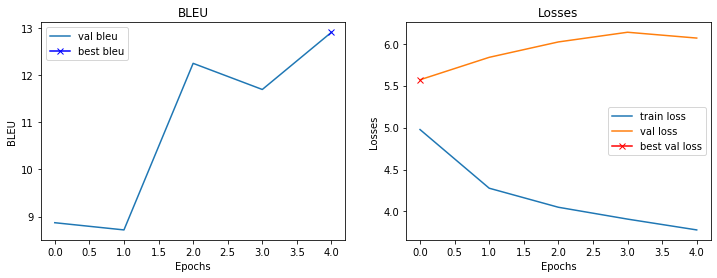

Epoch : 1800
Train example :
	Target: a woman wearing a purple jacket stands next to a horse .
	Output: a man is a black shirt and in to a man .
Random example:
	Target: a man walking along the platform at a subway station .
	Output: a man is standing in front of a building .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man is a a blue shirt and a blue shirt is sitting on a bench .
Train loss    : 3.699335253238678
Val loss      : 6.202917367219925
Val bleu      : 8.54043653727812



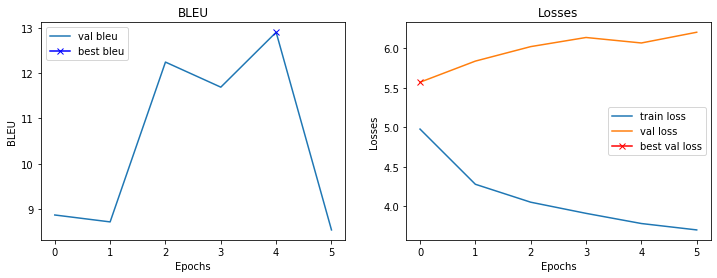

Epoch : 2100
Train example :
	Target: many people sitting at many tables .
	Output: a people are at a table .
Random example:
	Target: a man in a dark shiny suit plays the piano and sings on stage .
	Output: a man in a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is sitting on a bench with a yellow bucket .
Train loss    : 3.6309616573651633
Val loss      : 6.243588879704475
Val bleu      : 11.49012844961342



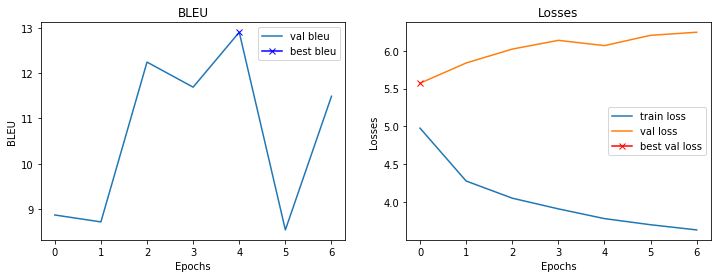

Epoch : 2400
Train example :
	Target: a boy is playing in a dark theater near the stage .
	Output: a man in playing a a park room . a street .
Random example:
	Target: a woman in a gray , long-sleeved shirt uses a machine at the gym .
	Output: a man in a blue shirt and a hat is standing in front of a building .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt and a blue shirt is sitting on a bench in a park .
Train loss    : 3.580892375310262
Val loss      : 6.222021922469139
Val bleu      : 10.930106045265294



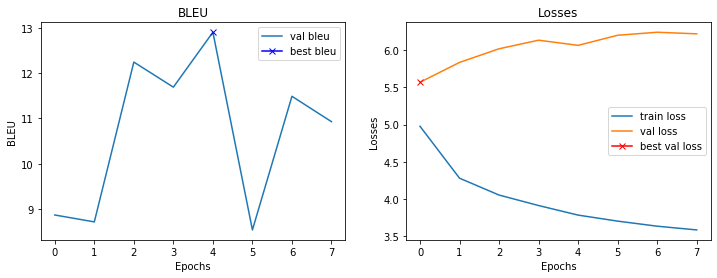

Epoch : 2700
Train example :
	Target: a woman in red is sitting on a bench .
	Output: a woman in a jeans walking on a bench .
Random example:
	Target: a person surfs through a wave as it crashes down .
	Output: a man in a blue shirt is standing on a rock .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a boat .
Train loss    : 3.547643743356069
Val loss      : 6.2098145335912704
Val bleu      : 13.302317668672146



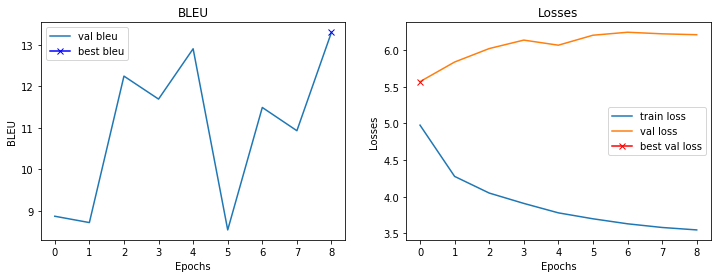

Epoch : 3000
Train example :
	Target: a boy is doing a skateboard trick on the boardwalk .
	Output: a man in jumping a trick trick . a skateboard .
Random example:
	Target: some people walking by the water .
	Output: a man in a red shirt and a woman in a black shirt and a woman in a black shirt and a woman
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a wooden structure .
Train loss    : 3.4983327849706014
Val loss      : 6.147655725479126
Val bleu      : 12.7813285758056



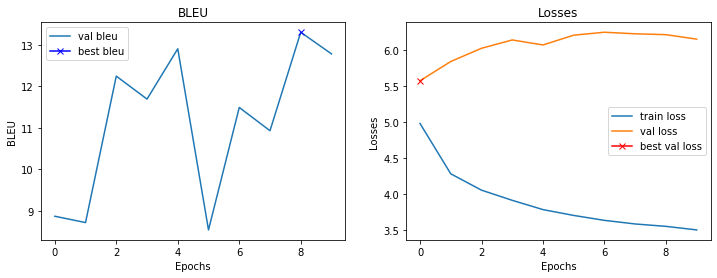

Epoch : 3300
Train example :
	Target: a long-haired man wearing a blue shirt and dark pants plays a guitar while sitting on a wood and metal bench with another man and woman in front of a UNK cafe rainbow mural .
	Output: a man man in a blue shirt and jeans pants is a guitar . a on a bench bench a wall . a man in a woman a of him man . . . .
Random example:
	Target: a little girl in a paisley dress runs across a sandy playground .
	Output: a little girl in a pink shirt and a pink shirt is playing a toy .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a boat .
Train loss    : 3.4711732880274453
Val loss      : 6.3853074461221695
Val bleu      : 12.178796767987858



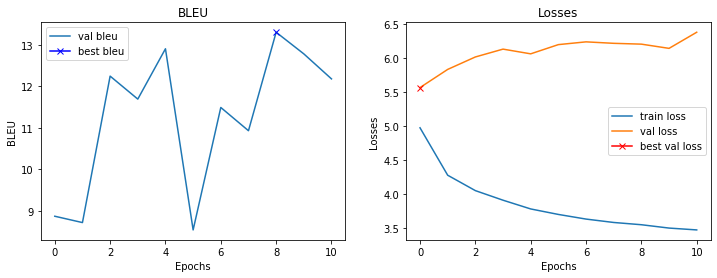

Epoch : 3600
Train example :
	Target: the boy is surfing .
	Output: a surfer is a in
Random example:
	Target: two cheerleaders in dark blue pants and bra style top with yellow pompoms mid cheer .
	Output: a man in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man is working on a boat .
Train loss    : 3.4020645666122435
Val loss      : 6.156984448432922
Val bleu      : 12.154942721714166



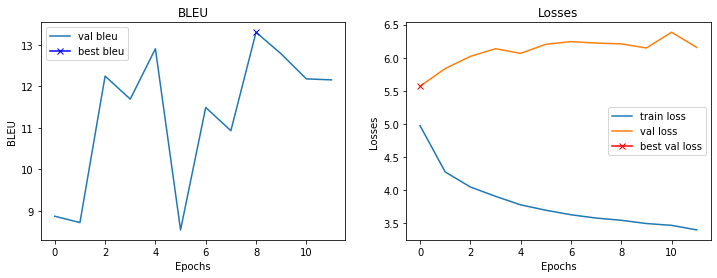

Epoch : 3900
Train example :
	Target: two men wearing work attire , stands next to an UNK , outside a large plant .
	Output: a men are standing on work and a to a orange . UNK of building . .
Random example:
	Target: a child with a helmet jumps over a pile of old tires .
	Output: a man in a blue shirt is standing on a bench .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is standing on a boat .
Train loss    : 3.3784120456377664
Val loss      : 6.229886159300804
Val bleu      : 12.839031709177245



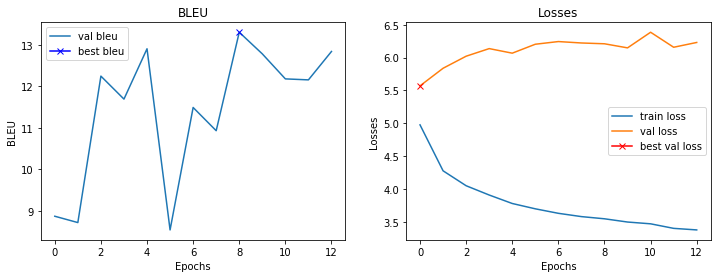

Epoch : 4200
Train example :
	Target: the cowboy is trying to take down the calf .
	Output: a horse horse is to catch a a dirt of
Random example:
	Target: two young people riding skateboards pass by in the street as a black dog on a red leash stops in a doorway and squats down on the sidewalk .
	Output: a man in a black jacket and a black jacket is walking down a street .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man is sitting on a bench with a blue bucket .
Train loss    : 3.362326342264811
Val loss      : 6.369368717074394
Val bleu      : 12.48838983318732



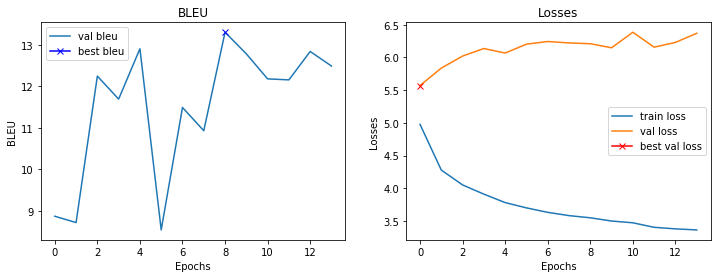

Epoch : 4500
Train example :
	Target: a black and white dog jumps over a bar .
	Output: a black dog white dog is over a hurdle .
Random example:
	Target: two men in suits are on a stage giving a presentation .
	Output: a man in a black shirt is playing a guitar .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is sitting on a boat .
Train loss    : 3.3202073486646015
Val loss      : 6.263496175408363
Val bleu      : 14.224938483641129



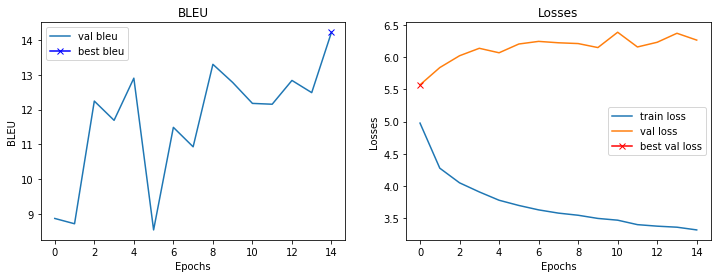

Epoch : 4800
Train example :
	Target: olympic bicyclists round a corner during competition .
	Output: a bikers are up race . a .
Random example:
	Target: six men sit in a field of crops containing wooden crates .
	Output: a group of people are standing on a bridge .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man is a a boat on a boat .
Train loss    : 3.305688768227895
Val loss      : 6.275382623076439
Val bleu      : 15.039691879115397



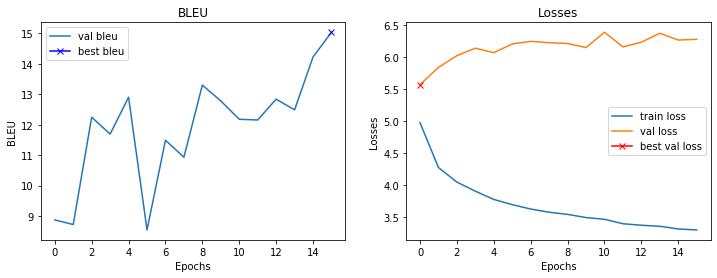

Epoch : 5100
Train example :
	Target: people are inside a cage riding horses .
	Output: a are a of race with on .
Random example:
	Target: a small child on a UNK swing ride at an amusement park .
	Output: a man in a red shirt is riding a bicycle on a beach .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing in a pool .
Train loss    : 3.2755487990379333
Val loss      : 6.315066143870354
Val bleu      : 12.500014572490029



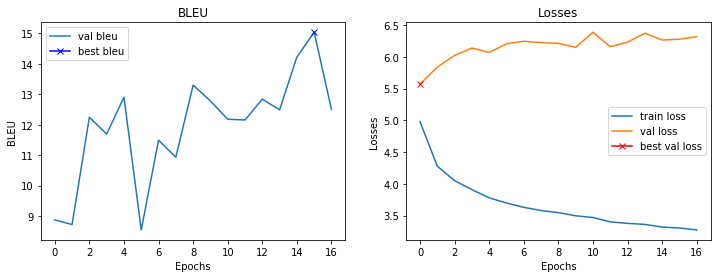

Epoch : 5400
Train example :
	Target: a man in a new york shirt waits to cross the street .
	Output: a man in a red york jacket is for a the street .
Random example:
	Target: two workers in yellow vests try to fix something .
	Output: a man in a blue shirt is standing on a ladder .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a boat .
Train loss    : 3.255065309206645
Val loss      : 6.261666417121887
Val bleu      : 14.980158172923963



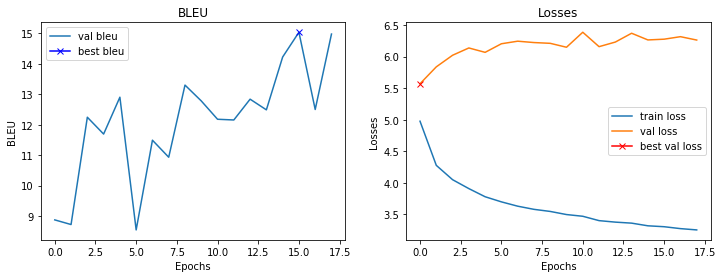

Epoch : 5700
Train example :
	Target: a man and a woman holding a camera are interacting in a chinatown marketplace .
	Output: a group in a woman are a shopping . walking . a parade . .
Random example:
	Target: a man is walking past a latin american produce shop .
	Output: a man in a white shirt and a white hat is standing in front of a store .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man is sitting on a boat .
Train loss    : 3.2465267157554627
Val loss      : 6.252493470907211
Val bleu      : 14.960353640632892



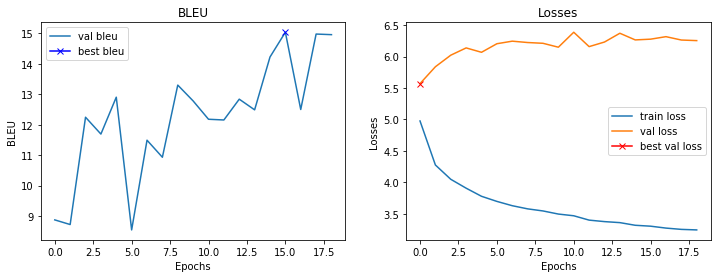

Epoch : 6000
Train example :
	Target: a woman pulls her raft into the water .
	Output: a man in a hair in the water .
Random example:
	Target: families are gathered in a park .
	Output: a group of people are sitting on a grass field .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is sitting on a dock with a large child in the background .
Train loss    : 3.2163094584147136
Val loss      : 6.235476613044739
Val bleu      : 15.271336516072997



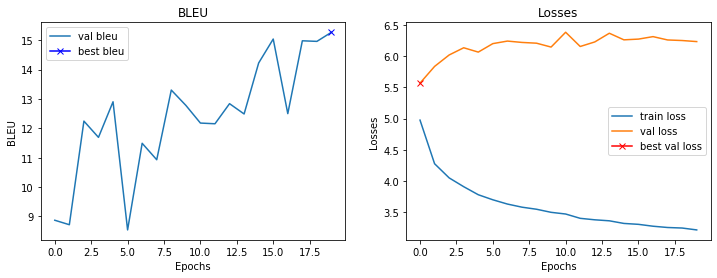

Epoch : 6300
Train example :
	Target: a man skis down a snowy hill .
	Output: a man in down a snowy hill .
Random example:
	Target: a soccer player removes his shirt .
	Output: a soccer player in a white uniform is running a football .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is working on a wooden structure .
Train loss    : 3.197328647772471
Val loss      : 6.312421441078186
Val bleu      : 14.83777001383787



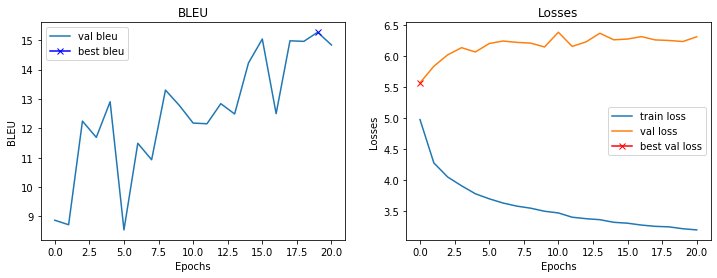

Epoch : 6600
Train example :
	Target: a shirtless man in front of a weathered brick wall outside .
	Output: a man man in a of a building tree wall . a
Random example:
	Target: a man wearing a number 3 jersey is about to kick a soccer ball .
	Output: a soccer player in a red jersey is kicking a ball .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is working on a roof .
Train loss    : 3.163303246498108
Val loss      : 6.328588828444481
Val bleu      : 16.239363013491094



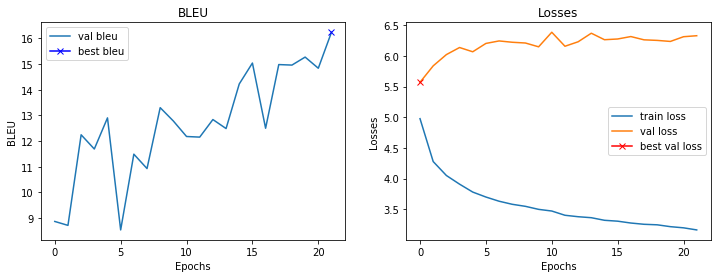

Epoch : 6900
Train example :
	Target: a woman with red-hair and a black shirt has her eyes closed and a mirror behind her .
	Output: a young with a and a black shirt and a mouth . . holding man . her .
Random example:
	Target: two young women posing for a picture
	Output: a woman in a black shirt and a woman in a black shirt and a woman in a black dress are dancing .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man is standing on a dock .
Train loss    : 3.173861837387085
Val loss      : 6.277709811925888
Val bleu      : 16.1395864548255



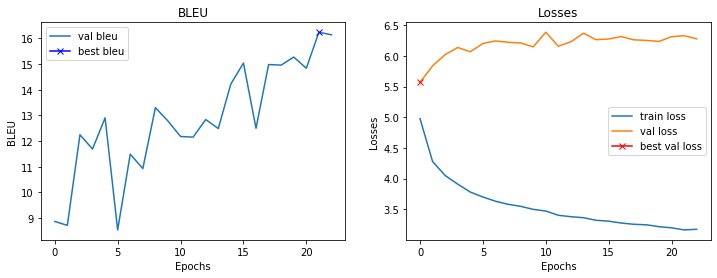

Epoch : 7200
Train example :
	Target: two men talk to each other behind an organ while a lone woman stands to their right .
	Output: a man are on a other . a open . a woman man is behind . him .
Random example:
	Target: a dog with one ear up runs outside through the fall leaves .
	Output: a dog is running through a field .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing in a boat .
Train loss    : 3.149186228116353
Val loss      : 6.363197460770607
Val bleu      : 15.923216286283267



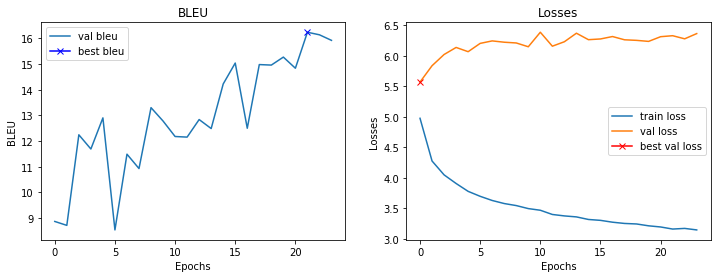

Epoch : 7500
Train example :
	Target: the new york city streets filled with UNK of people .
	Output: a crowd york city street . with people . people .
Random example:
	Target: a man in black pants and a white shirt crossing a bridge in front of a tan building .
	Output: a man in a blue shirt is standing on a bridge .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a boat .
Train loss    : 3.1573558751742046
Val loss      : 6.256200894713402
Val bleu      : 17.078242681327666



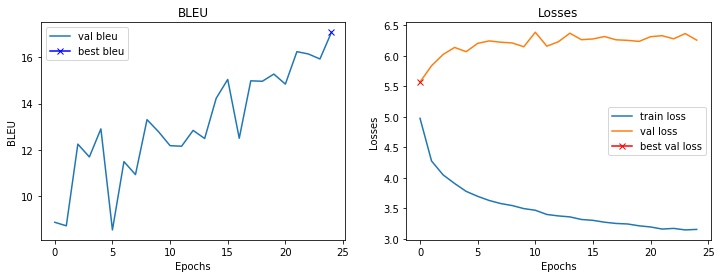

Epoch : 7800
Train example :
	Target: young girl sips a drink on a blue bench .
	Output: a girl in a baby from a beach tube .
Random example:
	Target: two people sit on a couch overlooking the view of a city .
	Output: a man in a white shirt is sitting in a chair with a woman in a white shirt .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is working on a dock .
Train loss    : 3.1152873277664184
Val loss      : 6.315988004207611
Val bleu      : 16.098744371090444



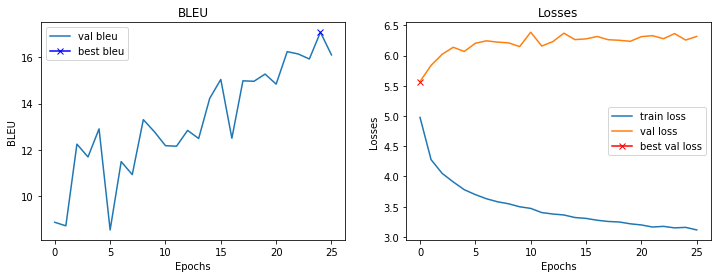

Epoch : 8100
Train example :
	Target: a man sits on a bench near the beach , tying his shoe .
	Output: a man in on a bench in a water . a a head .
Random example:
	Target: a man in an orange top and blue pants carries a lot of boxes while a woman pulling a pink bag goes in the other direction .
	Output: a man in a blue shirt and blue jeans is walking down a street .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt and blue jeans is standing on a dock .
Train loss    : 3.1289247115453085
Val loss      : 6.33647595345974
Val bleu      : 15.95694466162915



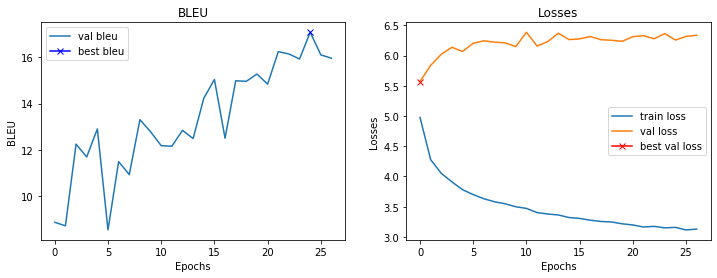

Epoch : 8400
Train example :
	Target: the girl in the blue coat is holding a purple UNK water bottle .
	Output: a man is wearing the jacket is talking a picture and white bottle .
Random example:
	Target: a crowd of people is facing the same direction while some hold their hands in the air .
	Output: a group of people are sitting on a stage .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is playing a basketball game .
Train loss    : 3.1313130100568136
Val loss      : 6.315527826547623
Val bleu      : 15.761748962524184



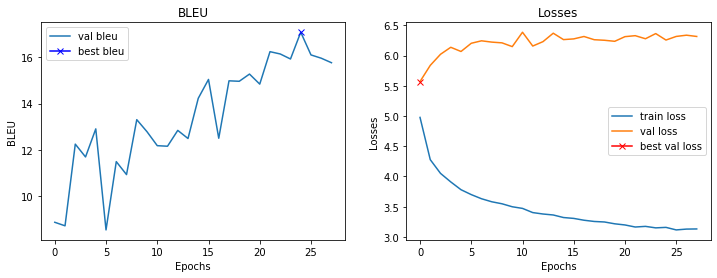

Epoch : 8700
Train example :
	Target: an asian woman dances with long ribbons , she is mid jump with her legs pointed to the right and the red ribbons flowing on either side of her
	Output: a asian woman is in a hair . and dances performing down . her arms in . her air . her air ribbon . her a her of a head
Random example:
	Target: a small white kid holding a black umbrella in front of him , in order to block the UNK water being shot out from a red firetruck in the parking lot .
	Output: a man in a red shirt and blue jeans is standing in front of a large building .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt and a woman in a white shirt and a man in a white shirt and a man in a white shirt
Train loss    : 3.0975496196746826
Val loss      : 6.378185540437698
Val bleu      : 14.406176028875208



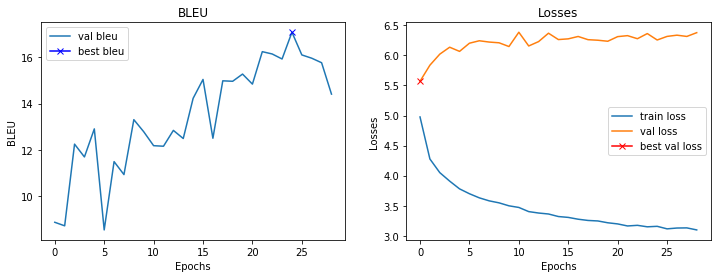

Epoch : 9000
Train example :
	Target: green trees , grass , one man standing , another bending down .
	Output: a man in a in and is is on and man down .
Random example:
	Target: a man with his shirt off standing in a work zone next to a pile of bricks .
	Output: a man in a blue shirt and blue jeans is standing on a dock .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man is a a fishing net .
Train loss    : 3.101385989189148
Val loss      : 6.271527051925659
Val bleu      : 15.901855162570733



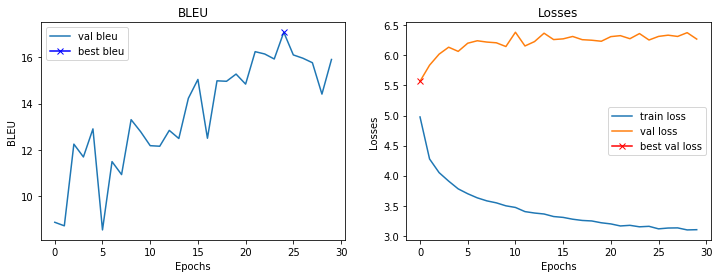

Epoch : 9300
Train example :
	Target: a little girl is licking a dinner plate and getting food all over her face .
	Output: a girl girl is eating a UNK . . a bowl . . a . .
Random example:
	Target: a girl dressed for winter stands in front of some graffiti .
	Output: a young girl in a red jacket and a red jacket is standing in the snow .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt and blue jeans is jumping into a pool .
Train loss    : 3.0580946707725527
Val loss      : 6.35341939330101
Val bleu      : 15.95417014592605



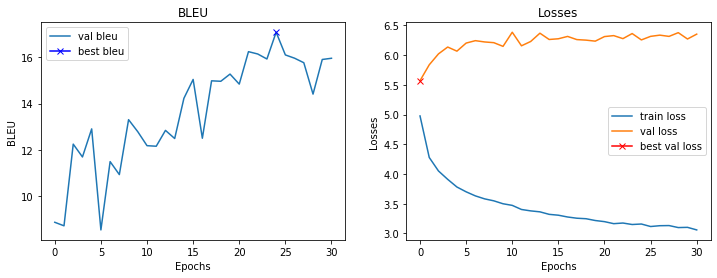

Epoch : 9600
Train example :
	Target: a woman in a blue outfit is upside down with her body UNK .
	Output: a gymnast in a red shirt is jumping on a a legs legs .
Random example:
	Target: a cowboy in a rodeo trying to beat the 8 second clock .
	Output: a man in a black shirt and black shorts is riding a horse .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a dock .
Train loss    : 3.0416447774569195
Val loss      : 6.399686768651009
Val bleu      : 16.03159491009776



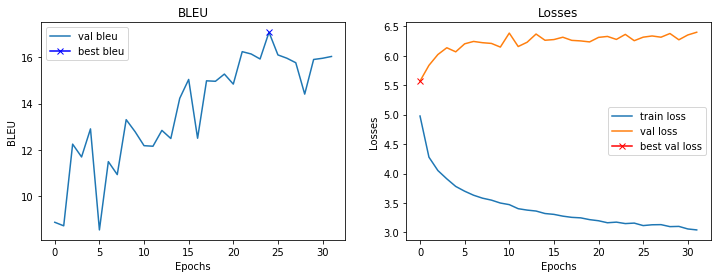

Epoch : 9900
Train example :
	Target: a man is kissing the forehead of a baby that is lying on a couch .
	Output: a man is sitting a baby of a woman . is sitting on a couch .
Random example:
	Target: a man wearing a white shirt taking a nap with a green hat over his eyes .
	Output: a man in a brown jacket is riding a horse .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is standing on a dock .
Train loss    : 3.022696722348531
Val loss      : 6.274962916970253
Val bleu      : 16.499562855568904



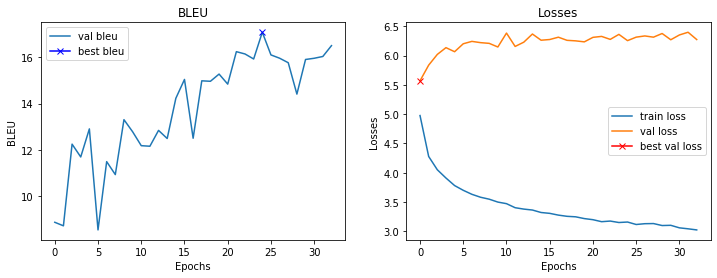

Epoch : 10200
Train example :
	Target: guy in art UNK glass home .
	Output: a sitting in in in a .
Random example:
	Target: college students enjoy time out of class in a field .
	Output: a man in a blue shirt is holding a small boy in a blue shirt .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man is standing on a dock with a blue bucket .
Train loss    : 3.032446687221527
Val loss      : 6.361725777387619
Val bleu      : 15.861807851007887



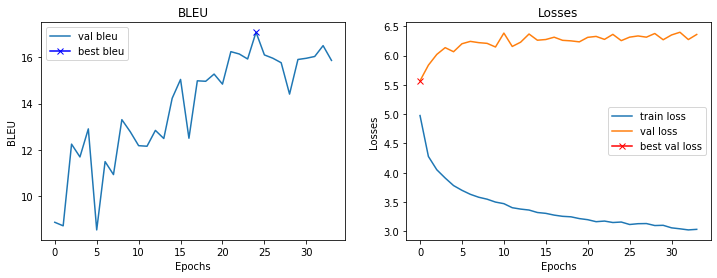

Epoch : 10500
Train example :
	Target: a crowd of people gathered around the exit while a large ship is featured on the tv screen .
	Output: a man of people are around a table of a man of . nearby . the side . .
Random example:
	Target: a man and his children ride a four-wheeler outside .
	Output: a man in a blue shirt is sitting on a bench with a cart .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a dock with a yellow bucket .
Train loss    : 3.057116765975952
Val loss      : 6.290173411369324
Val bleu      : 17.28956630875361



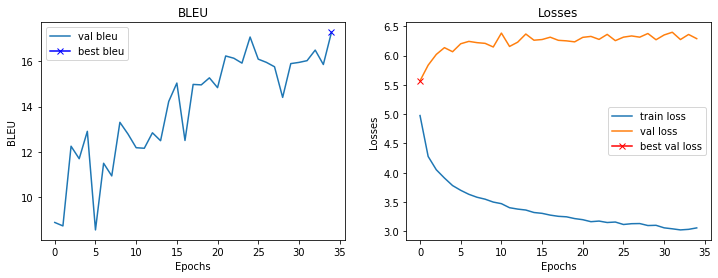

Epoch : 10800
Train example :
	Target: a fluffy white dog runs through the woods with his ears flapping in the breeze .
	Output: a white dog dog is through the grass . a mouth . . the air .
Random example:
	Target: two barefoot female ethnic dancers perform in colorful traditional garb .
	Output: a woman in a white dress is dancing with a man in a white dress .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man is playing a game of water .
Train loss    : 3.0233324273427327
Val loss      : 6.264011487364769
Val bleu      : 16.568055657742363



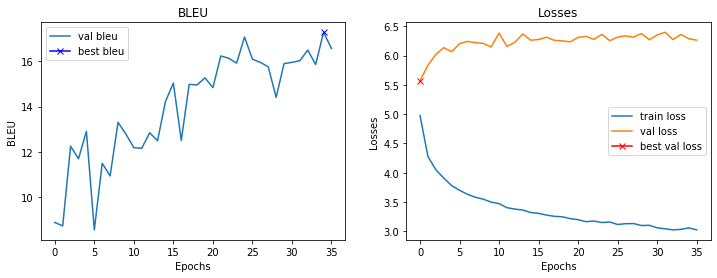

Epoch : 11100
Train example :
	Target: children playing in an outdoor pool as a woman watches from the side .
	Output: a are in the outdoor fountain .
Random example:
	Target: woman in ethnic garments dancing .
	Output: a woman in a red shirt and blue jean shorts is holding a yellow flag .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man is playing a game of a pool .
Train loss    : 3.0086371660232545
Val loss      : 6.2998896688222885
Val bleu      : 16.21433895244958



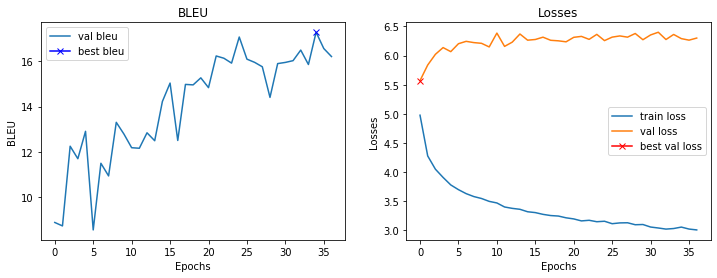

Epoch : 11400
Train example :
	Target: asian men sit on a bench .
	Output: a man in on a bench talking
Random example:
	Target: a young woman wearing native dress is working with a frame .
	Output: a woman and a child are sitting on a couch .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is working on a piece of wood .
Train loss    : 3.0130886514981587
Val loss      : 6.309278920292854
Val bleu      : 16.25187136455191



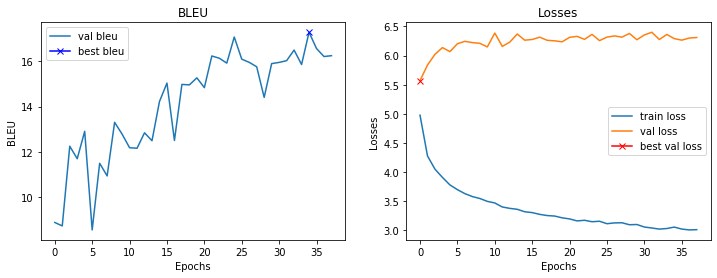

Epoch : 11700
Train example :
	Target: a woman in a white polo shirt is moving a black statue of a bear .
	Output: a man in a white shirt shirt is holding a man dog of a man animal
Random example:
	Target: a brunette woman wearing dark glasses and a red blouse is eating .
	Output: a woman in a black shirt and a black shirt is looking at a camera .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man is a blue shirt is playing a pool .
Train loss    : 2.995958691438039
Val loss      : 6.291156321763992
Val bleu      : 16.350405918068677



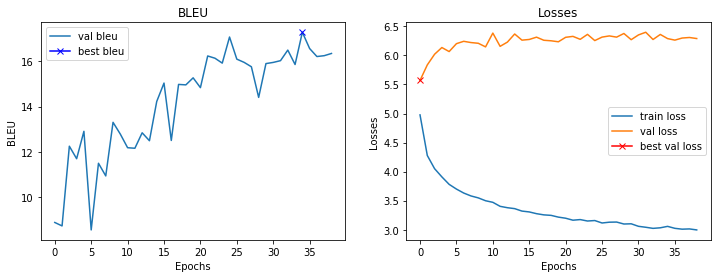

Epoch : 12000
Train example :
	Target: a young man in a hard hat and safety vest sitting in a pickup while another man holds on in the passenger seat .
	Output: a man in wearing a blue hat and a hat is on a blue . a man is a the the back seat .
Random example:
	Target: a man putting shingles on a roof .
	Output: a man in a blue shirt and jeans is sitting on a bench with his foot on a wooden bench .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a dock with a large wooden bucket .
Train loss    : 2.997503224213918
Val loss      : 6.409281030297279
Val bleu      : 16.304844553517377



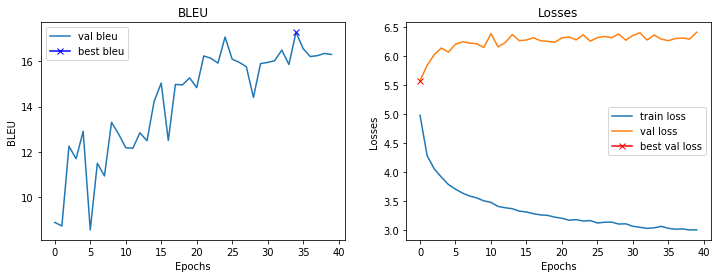

Epoch : 12300
Train example :
	Target: a man in black shorts is boxing against and man in white shorts .
	Output: a man in a shorts and a . a another in a . .
Random example:
	Target: a group of women in matching outfits surrounds musicians on a street .
	Output: a man in a black shirt and jeans is standing in front of a group of people .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a yellow shirt is standing in a pool with a yellow bucket .
Train loss    : 2.984229868253072
Val loss      : 6.2903259843587875
Val bleu      : 16.535818341318965



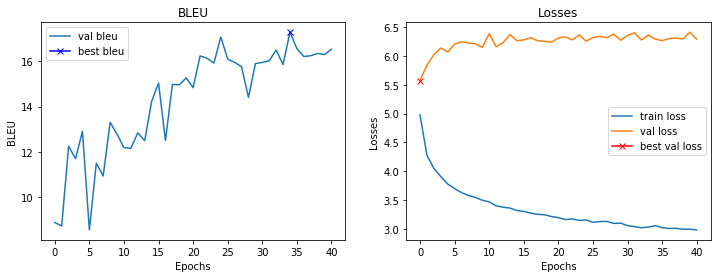

Epoch : 12600
Train example :
	Target: a person in a uniform waiting next to luggage near an open plane door with two other people in the background .
	Output: a man is a white a for a picture .
Random example:
	Target: a beige dog and brown dog in the snow .
	Output: a dog is playing with a dog in the snow .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is playing a game of water .
Train loss    : 2.9894271326065063
Val loss      : 6.31190413236618
Val bleu      : 16.580082084403262



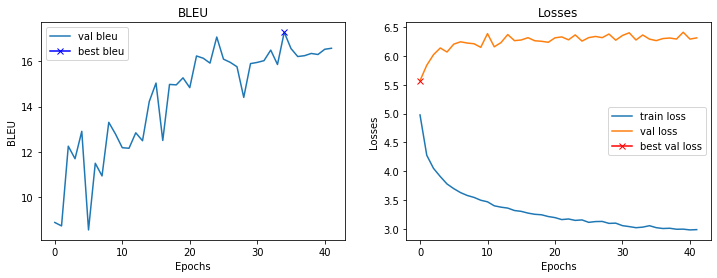

Epoch : 12900
Train example :
	Target: a man dressed as a mariachi player holds a small guitar and sings .
	Output: a man in in a pirate plays is a microphone guitar . a into
Random example:
	Target: a child in a light blue shirt crying .
	Output: a young boy is holding a crying baby .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is playing with a fountain .
Train loss    : 2.9889572191238405
Val loss      : 6.441628500819206
Val bleu      : 15.699482568304685



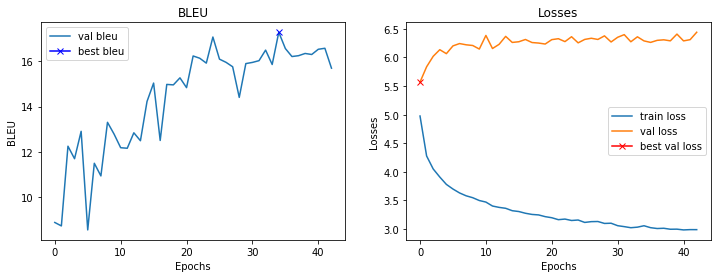

Epoch : 13200
Train example :
	Target: one man , shirtless , and a woman , clothed , jumping in the water .
	Output: a man is standing in while two man in both in and in the water .
Random example:
	Target: a man holding a child 's hand as they walk .
	Output: a man in a blue shirt and jeans is standing on a sidewalk .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a dock with a bucket in his mouth .
Train loss    : 2.9594346356391905
Val loss      : 6.304203391075134
Val bleu      : 16.8222279888603



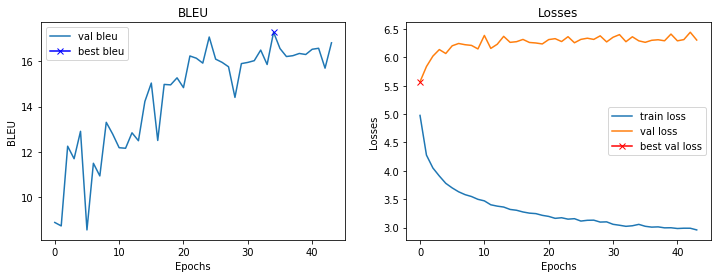

Epoch : 13500
Train example :
	Target: a man known as UNK speaks at a UNK .
	Output: a man in a he UNK . a UNK .
Random example:
	Target: a boy runs along a beach while a group of young girls watch .
	Output: a little girl in a pink shirt is playing with a beach .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a dock .
Train loss    : 2.956966250737508
Val loss      : 6.272523075342178
Val bleu      : 17.080111813676403



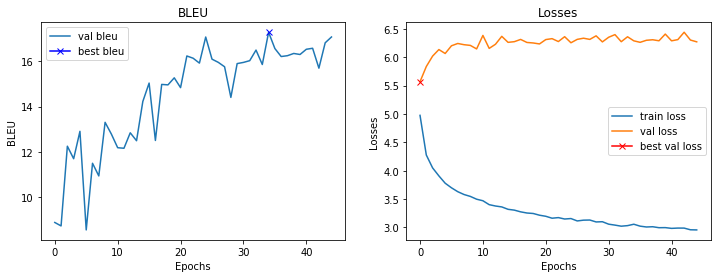

Epoch : 13800
Train example :
	Target: a girl in a red and white costume standing on the street .
	Output: a woman in a red and white striped is in a street .
Random example:
	Target: two baseball players trying to catch a ball in the outfield .
	Output: a man in a white shirt and white shorts is playing a sport .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a red shirt is playing a game of water .
Train loss    : 2.9497327113151552
Val loss      : 6.357857123017311
Val bleu      : 16.526547010107407



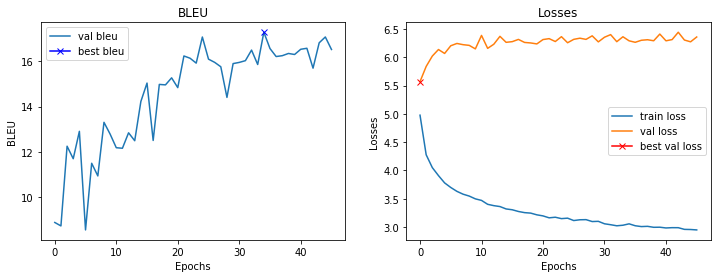

Epoch : 14100
Train example :
	Target: busy marketplace in an arabian country .
	Output: people in in a outdoor country .
Random example:
	Target: two males are running in an uncrowded area .
	Output: a man is playing a game on a beach .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man is cleaning a boat on a pier .
Train loss    : 2.952202608585358
Val loss      : 6.272245839238167
Val bleu      : 16.129249693252664



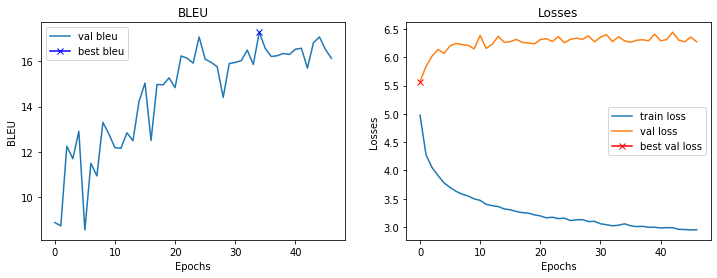

Epoch : 14400
Train example :
	Target: four people playing soccer on a brown surface .
	Output: a man in a on a beach field .
Random example:
	Target: a tennis player in a red outfit .
	Output: a woman in a white shirt and white shorts is playing tennis .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a yellow shirt is cleaning a pool .
Train loss    : 2.939015858968099
Val loss      : 6.38940654695034
Val bleu      : 16.10865907965134



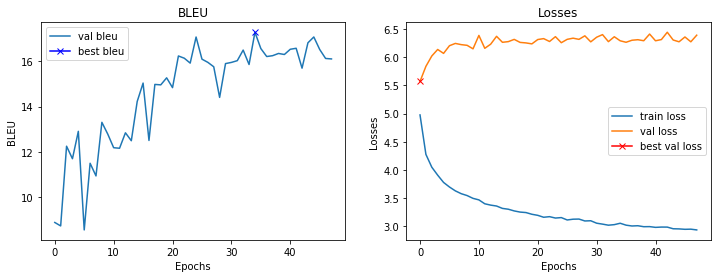

Epoch : 14700
Train example :
	Target: a man wit a green collared shirt and a camera sits at a curb .
	Output: a man in a cigarette shirt and and a woman . on a table .
Random example:
	Target: a UNK street artist draws a caricature of a redheaded woman on the side of the street .
	Output: a woman in a black shirt is sitting on a chair with a woman in a white shirt .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is cleaning a fish .
Train loss    : 2.927262820402781
Val loss      : 6.321098983287811
Val bleu      : 15.988368911598158



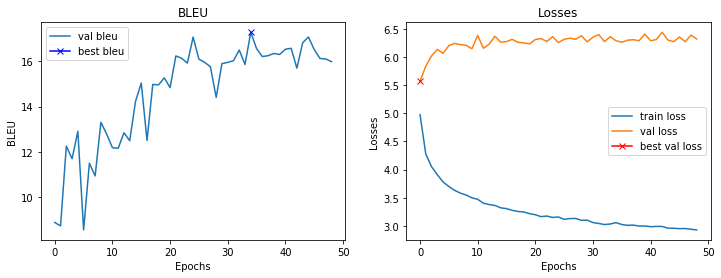

Epoch : 15000
Train example :
	Target: hiker walking along high rocks in front of a blue sky with puffy white clouds .
	Output: a in on side rocks . the of a mountain sky . mountains in clouds .
Random example:
	Target: two children are running down the sidewalk in front of a building .
	Output: a man in a white shirt and jeans is sitting on a bench with his hands on his head .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is working on a boat .
Train loss    : 2.9275528899828593
Val loss      : 6.30790251493454
Val bleu      : 16.586244385602917



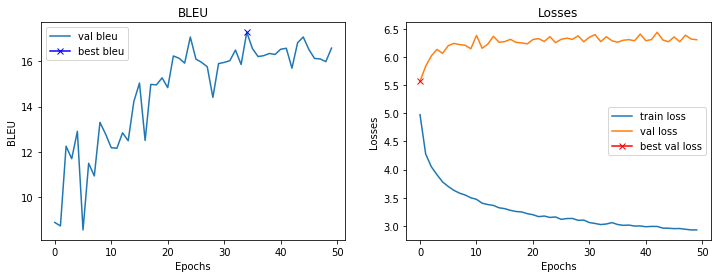

Epoch : 15300
Train example :
	Target: a young girl UNK off by a fountain in a park .
	Output: a man girl in a a a fountain . a city .
Random example:
	Target: a woman in a pink skirt is serving a ball in a tennis game .
	Output: a woman in a white shirt and white shorts is playing tennis .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a group of people are playing in a pool .
Train loss    : 2.9107336815198264
Val loss      : 6.337863266468048
Val bleu      : 17.578283683426438



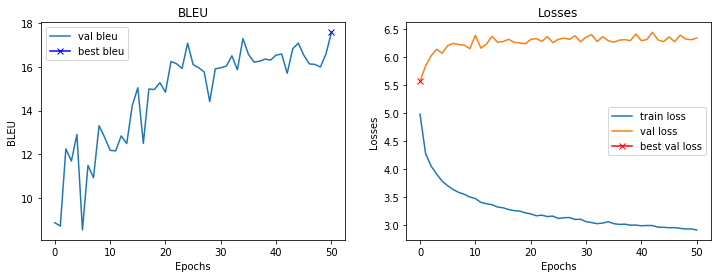

Epoch : 15600
Train example :
	Target: a person is taking a walk on a rocky trail .
	Output: a man in walking a break down a mountain trail .
Random example:
	Target: two women , one with tattoos , hold each other and smile .
	Output: a woman in a black shirt is laughing while holding a microphone .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a ladder .
Train loss    : 2.9038945484161376
Val loss      : 6.50499002635479
Val bleu      : 16.294771590934978



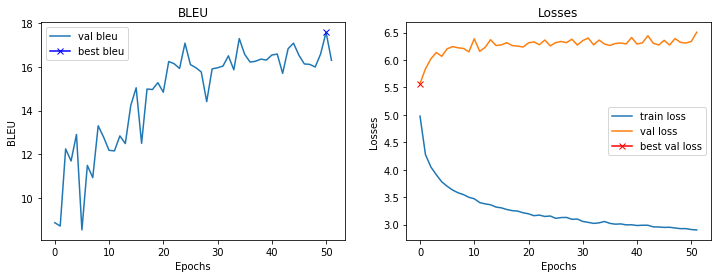

Epoch : 15900
Train example :
	Target: a group of people standing in the water on a sunny day .
	Output: a group of people are on the water . a beach day .
Random example:
	Target: four girls are sitting in a hot tub .
	Output: a man and a woman are sitting in a pool .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man is standing on a ladder with a bucket in his hand .
Train loss    : 2.909173209667206
Val loss      : 6.431545928120613
Val bleu      : 16.851545605104032



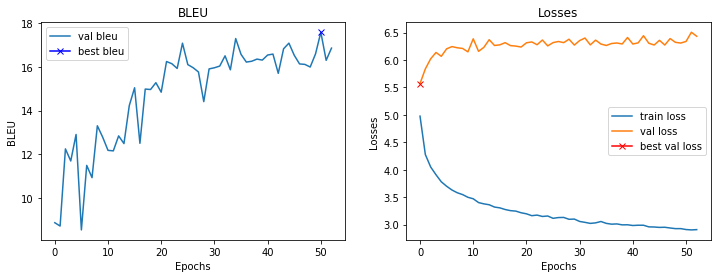

Epoch : 16200
Train example :
	Target: a black limo is parked next to a crowded staircase .
	Output: a man and is parked in to a building street .
Random example:
	Target: two UNK in a field .
	Output: a brown dog is jumping over a fence .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.900412387053172
Val loss      : 6.469209432601929
Val bleu      : 16.856530503466995



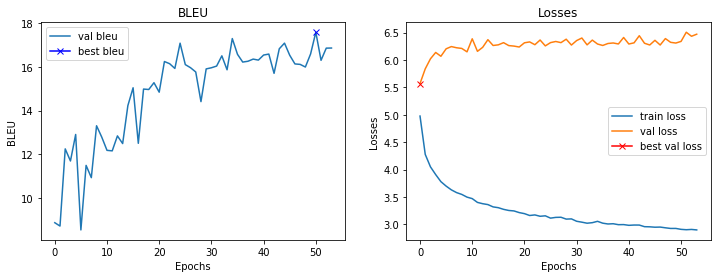

Epoch : 16500
Train example :
	Target: young black girl riding pony at petting zoo .
	Output: a man man in a horse a zoo .
Random example:
	Target: a woman with a pink shirt walks down the street .
	Output: a group of people are sitting on a bench .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is working on a boat .
Train loss    : 2.9029033470153807
Val loss      : 6.35473470389843
Val bleu      : 17.753253064456885



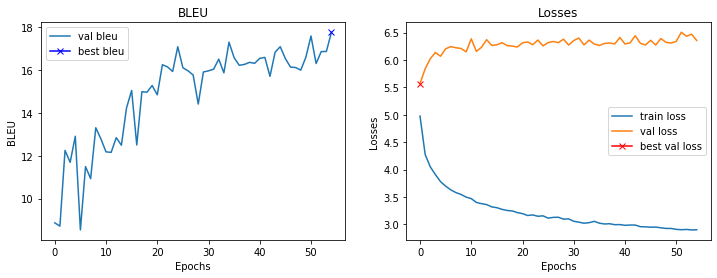

Epoch : 16800
Train example :
	Target: a person rides a bike in front of an elaborately painted building .
	Output: a man is a bicycle in a city a large UNK building .
Random example:
	Target: a tall man in a green sweater is holding his hands out at chest height like he is holding a book in a room of 3 people .
	Output: a man in a suit is talking to a man in a suit .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is standing on a dock with a fishing pole .
Train loss    : 2.889961978594462
Val loss      : 6.318895950913429
Val bleu      : 17.45842596560844



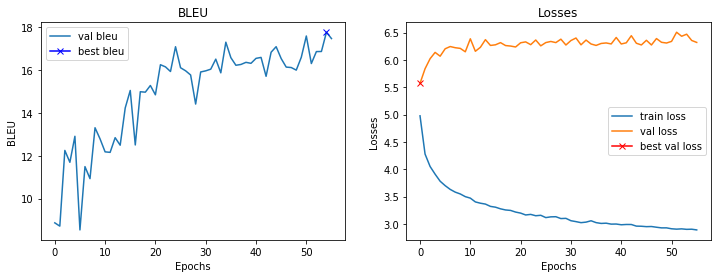

Epoch : 17100
Train example :
	Target: a man rows a boat in a lake near mountains .
	Output: a man in of boat on the lake . a .
Random example:
	Target: three men sit outside of a cafe .
	Output: a group of people are sitting at a table in front of a large building .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is standing on a ladder .
Train loss    : 2.9005561979611714
Val loss      : 6.479902401566505
Val bleu      : 16.75611319578735



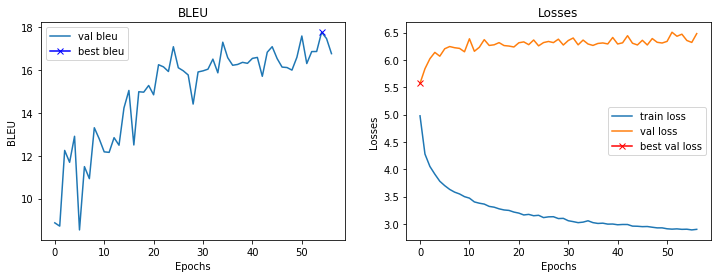

Epoch : 17400
Train example :
	Target: five UNK playing on the street .
	Output: a people are a a street .
Random example:
	Target: an old woman in a scarf is in the city .
	Output: a man with a hat is holding a sign .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is standing on a dock , with a man in a blue shirt and blue shorts is playing with a ball .
Train loss    : 2.8933052221934
Val loss      : 6.451884493231773
Val bleu      : 16.66050748495086



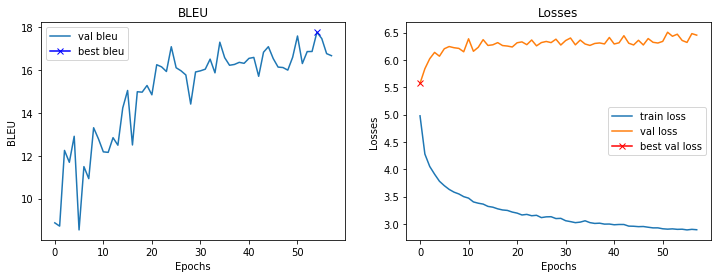

Epoch : 17700
Train example :
	Target: people under a blue umbrella walking .
	Output: a are a umbrella umbrella and down
Random example:
	Target: a man and child are laughing together .
	Output: a man and a woman are sitting on a couch .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a dock .
Train loss    : 2.8607400314013165
Val loss      : 6.515709802508354
Val bleu      : 15.769532934053613



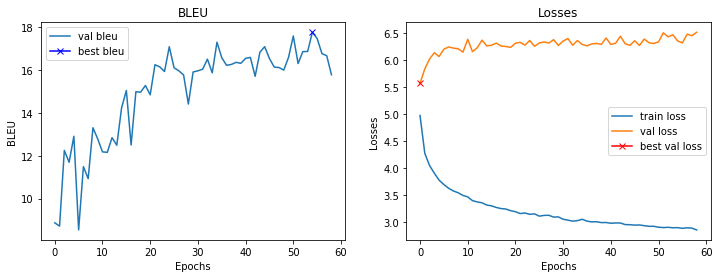

Epoch : 18000
Train example :
	Target: a seagull watches a woman in a sweater and scarf reading the newspaper .
	Output: a woman sits a man sitting a black shirt white . on park .
Random example:
	Target: a man wearing all black sits on a wooden bench and reads , his umbrella is open nearby on the ground .
	Output: a man in a red jacket is walking down a sidewalk .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing in a pool with a yellow bucket .
Train loss    : 2.886367201010386
Val loss      : 6.411638215184212
Val bleu      : 16.513968133026264



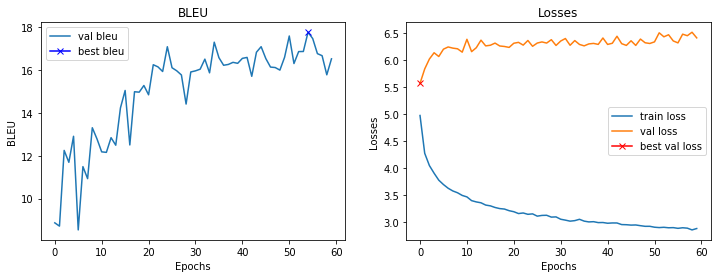

Epoch : 18300
Train example :
	Target: customers shopping in food court market .
	Output: a are at a at . .
Random example:
	Target: the man in a blue shirt , wearing a helmet , is readying to climb .
	Output: a man in a red shirt is climbing up a rock wall .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is standing on a deck , while a man in a blue shirt is on the floor .
Train loss    : 2.8610610699653627
Val loss      : 6.411916896700859
Val bleu      : 17.28224126752804



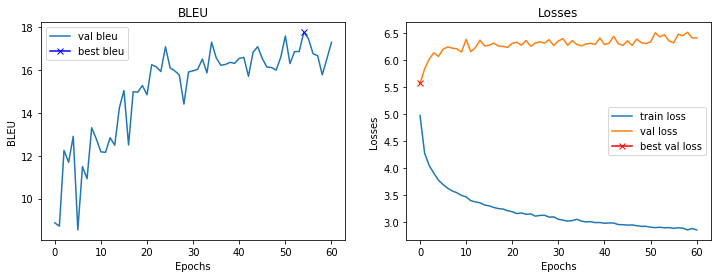

Epoch : 18600
Train example :
	Target: construction workers in overalls working .
	Output: a workers are hard are on
Random example:
	Target: a man and a woman is walking with a dog across a beach
	Output: a dog runs along the beach .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is cleaning a large pool .
Train loss    : 2.8581187518437705
Val loss      : 6.378653302788734
Val bleu      : 17.107789691971753



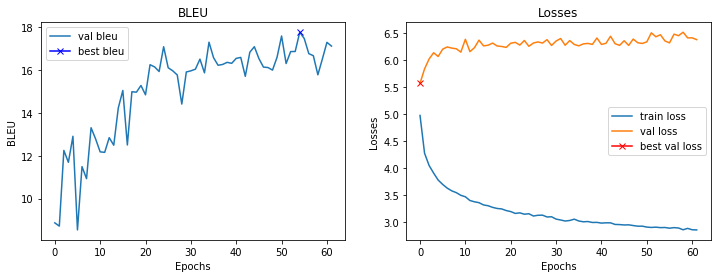

Epoch : 18900
Train example :
	Target: a lady is wearing jeans and a cardboard costume designed to look like the cartoon character UNK
	Output: a group in walking a black a crowd bag .
Random example:
	Target: a group of UNK are walking in the city .
	Output: a man in a red shirt and black pants is walking down the street .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a dock , with a man in a blue shirt and blue shorts .
Train loss    : 2.869198630650838
Val loss      : 6.313112527132034
Val bleu      : 17.75268114163345



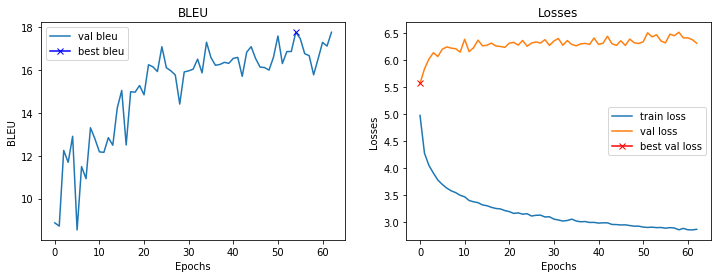

Epoch : 19200
Train example :
	Target: a young teenage girl talks to another teenager with a red sweatshirt .
	Output: a woman girl girl in on a man in a bike helmet .
Random example:
	Target: a man covering a mailbox with a black trash bag .
	Output: a man in a black shirt and jeans is standing in front of a blue wall with a sign on it .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is cleaning the floor of a pool .
Train loss    : 2.8442002177238463
Val loss      : 6.464038893580437
Val bleu      : 17.34229082917069



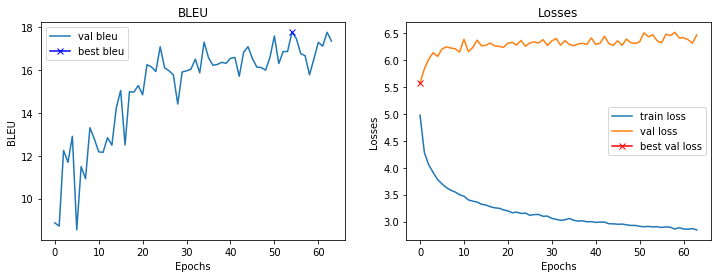

Epoch : 19500
Train example :
	Target: a man grins and holds up a white coffee cup while sitting near a tree .
	Output: a man with at a a a cup and . . his on a tree .
Random example:
	Target: a woman in a brown , UNK jacket and green boots watches some activity high in the grating along a quiet street .
	Output: a man in a black shirt is walking down a sidewalk .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is standing on a deck with a water bottle .
Train loss    : 2.8477153404553732
Val loss      : 6.332892447710037
Val bleu      : 17.674009042698998



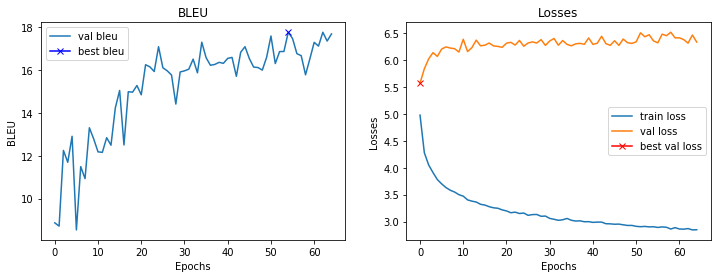

Epoch : 19800
Train example :
	Target: a baby in blue is standing on a sidewalk .
	Output: a man in a jeans walking on a sidewalk .
Random example:
	Target: a woman wearing a red helmet is holding a rope and smiling .
	Output: a man in a red shirt is holding a bike .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a yellow shirt is cleaning a pool .
Train loss    : 2.8460923234621682
Val loss      : 6.383898124098778
Val bleu      : 17.90013008843854



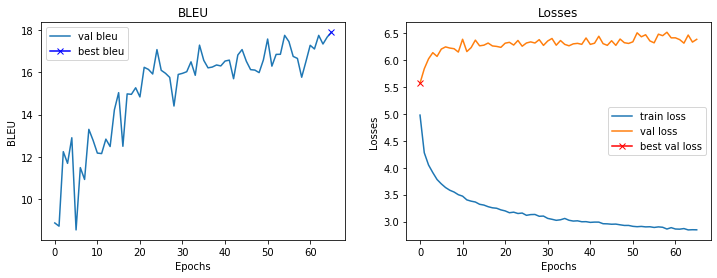

Epoch : 20100
Train example :
	Target: the brown dog is playing with a stick .
	Output: a brown dog is running with a stick in
Random example:
	Target: a worker rests his foot on the back of a trailer .
	Output: a man in a blue shirt is standing in front of a truck truck .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a ladder with a yellow bucket .
Train loss    : 2.830719554424286
Val loss      : 6.289492338895798
Val bleu      : 18.491662816457506



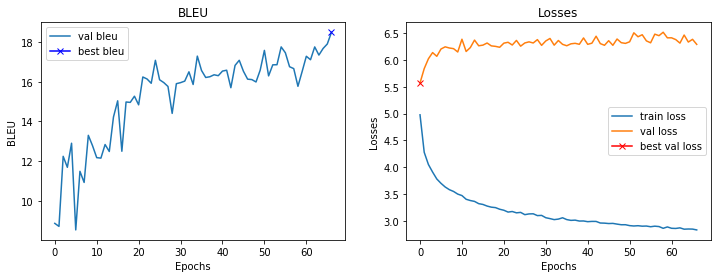

Epoch : 20400
Train example :
	Target: a man in a white t-shirt with a red logo is wearing colored beads whilst carrying a flag past a row of spectators .
	Output: a woman in a red shirt and red red shirt is juggling a beads . a a torch . a pole of people .
Random example:
	Target: a little girl is running .
	Output: a little girl in a pink dress is playing with a hula hoop .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is standing on a dock , with a man in a white shirt and shorts .
Train loss    : 2.8447601215044656
Val loss      : 6.405290991067886
Val bleu      : 16.932637137849664



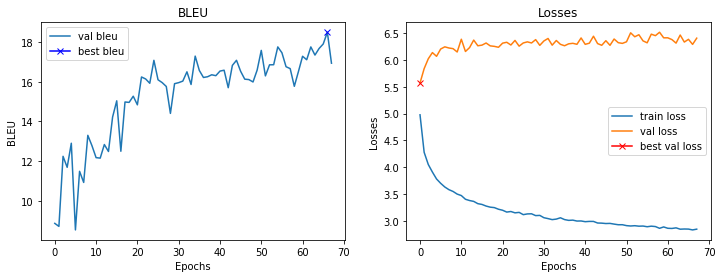

Epoch : 20700
Train example :
	Target: there is a girl creating art in this picture .
	Output: a is a man in a on the bathroom .
Random example:
	Target: a young man standing outside of a fire stairway .
	Output: a man in a blue shirt and jeans is standing on a ladder .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.813868385155996
Val loss      : 6.468708351254463
Val bleu      : 17.086925885801058



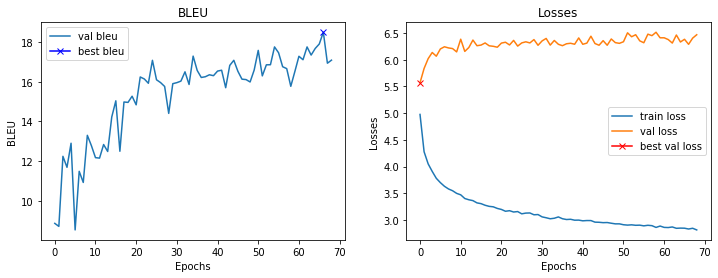

Epoch : 21000
Train example :
	Target: two girls read from a book together .
	Output: two women are a a book in .
Random example:
	Target: a dog running down a paved road .
	Output: a small dog is running through the sand .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a ladder with a yellow bucket .
Train loss    : 2.809185713926951
Val loss      : 6.39109294116497
Val bleu      : 18.013348481682105



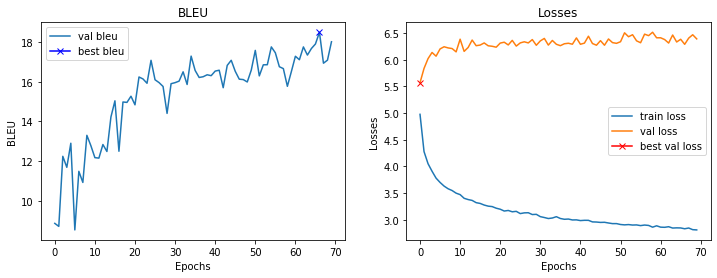

Epoch : 21300
Train example :
	Target: a person is sledding down a hill of snow , with an expression of excitement on their face .
	Output: a young in sledding down a snowy hill a . with a umbrella on snow . the . .
Random example:
	Target: a shirtless man is being filmed in the middle of a soccer field .
	Output: a soccer game is being played by a man in a blue shirt .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.830469759305318
Val loss      : 6.382076799869537
Val bleu      : 16.671250500703515



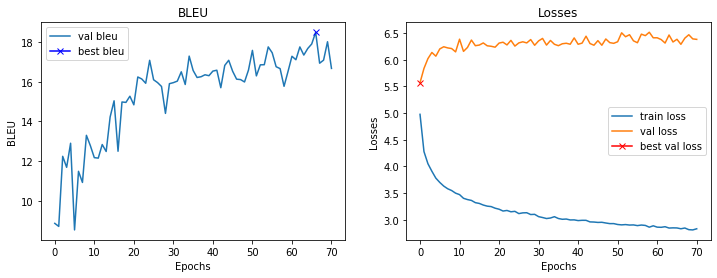

Epoch : 21600
Train example :
	Target: a lady in capri jeans and dark sleeveless top watches some guys preparing for a race .
	Output: a group in a shorts and a pants is is a people on a a street .
Random example:
	Target: two girls playing at the beach one in pink and the other in black .
	Output: a woman in a blue shirt and jeans is walking on the beach .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.8060599303245546
Val loss      : 6.499880984425545
Val bleu      : 17.28608829209951



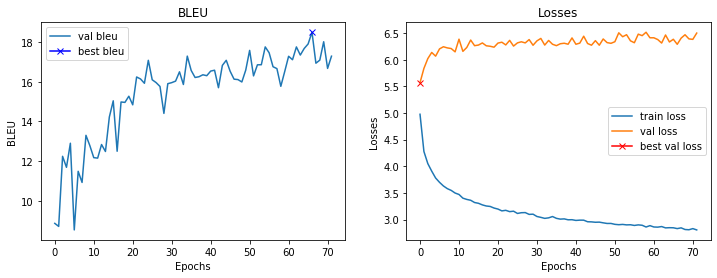

Epoch : 21900
Train example :
	Target: children gather happily around a toy .
	Output: a are in in a train train
Random example:
	Target: a man playing a xylophone in an open area .
	Output: a man in a white shirt and blue jeans is sitting on a stool with a man in a white shirt and jeans .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a yellow shirt is cleaning a pool .
Train loss    : 2.7930834682782493
Val loss      : 6.451941609382629
Val bleu      : 18.019973128586873



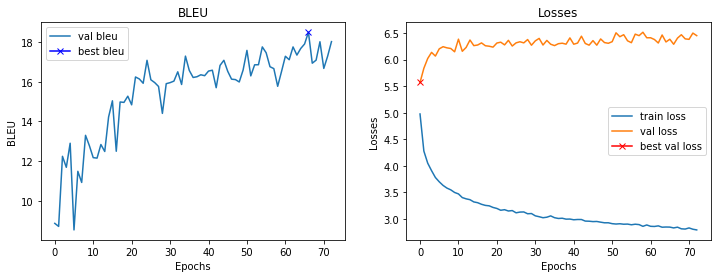

Epoch : 22200
Train example :
	Target: a red uniformed football player tackles an opposing player .
	Output: a football football football player is the player player in
Random example:
	Target: four people outside , three of whom are seated males .
	Output: a group of people sitting on a park bench .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is working on a boat .
Train loss    : 2.7972026952107747
Val loss      : 6.473944798111916
Val bleu      : 17.33968027709477



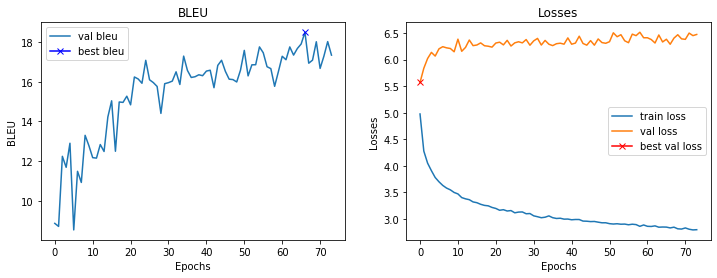

Epoch : 22500
Train example :
	Target: a red-haired clown cries streams of tears in a white hat on stage .
	Output: a man woman wearing to . a . a parade shirt . .
Random example:
	Target: old woman in headscarf and glasses stands outside in a big city .
	Output: a man with a beard and sunglasses is holding a sign .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.796591246128082
Val loss      : 6.352302759885788
Val bleu      : 17.860559686454685



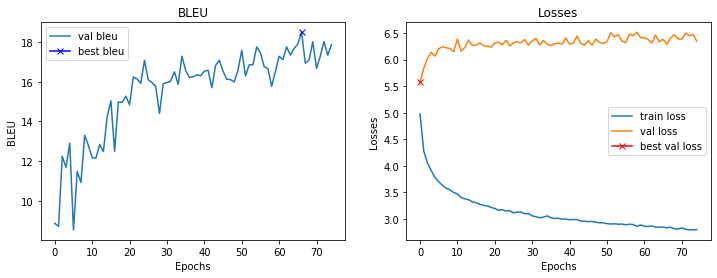

Epoch : 22800
Train example :
	Target: the two dogs are running on the grass .
	Output: a brown dogs are running through the grass .
Random example:
	Target: asian mom holding tiny infant .
	Output: a baby is holding a baby .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a yellow shirt is cleaning a pool .
Train loss    : 2.805772444407145
Val loss      : 6.376012161374092
Val bleu      : 17.553614863388223



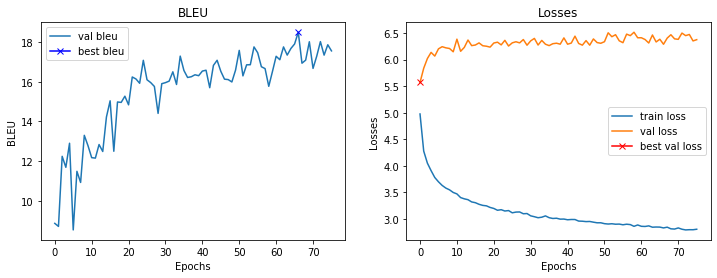

Epoch : 23100
Train example :
	Target: a group of friends stand in front of art they have sprayed for a picture .
	Output: a group of people are on front of a building are UNK . a . .
Random example:
	Target: a person on a motorcycle going uphill on rocky terrain
	Output: a man in a red helmet is riding a bike on a dirt road .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is cleaning the water .
Train loss    : 2.801598578294118
Val loss      : 6.412376061081886
Val bleu      : 17.821119018697516



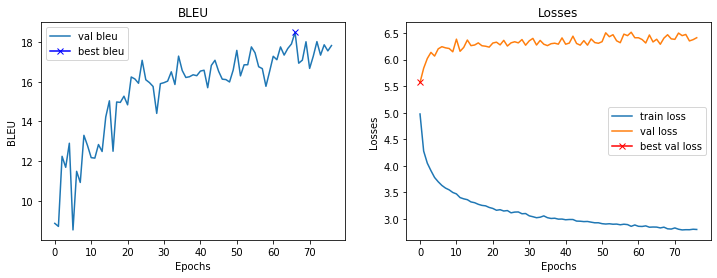

Epoch : 23400
Train example :
	Target: a blond woman with a white tank top and white pants is holding a UNK while standing in a lobby with doors behind her .
	Output: a woman woman is a gray shirt top is black pants is sitting a cellphone in she in front of . a . her .
Random example:
	Target: three dogs run through a manicured lawn .
	Output: a white and white dog is running on a grassy field .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.8041287620862323
Val loss      : 6.390079140663147
Val bleu      : 16.826833845230194



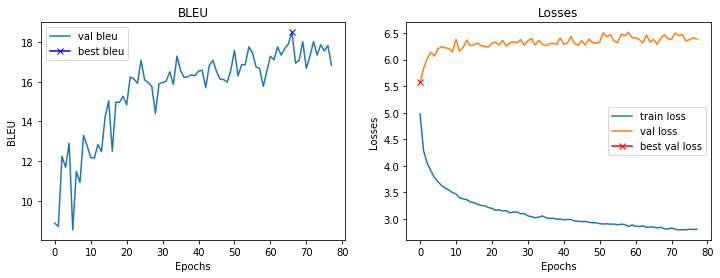

Epoch : 23700
Train example :
	Target: a woman outside of the subway giving directions .
	Output: a woman and a store street . a to
Random example:
	Target: a man holding the collar of a young rottweiler .
	Output: a black and brown dog is playing with a ball in the sand .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a red shirt is cleaning a pool .
Train loss    : 2.7634464279810587
Val loss      : 6.440436571836472
Val bleu      : 17.478092343170218



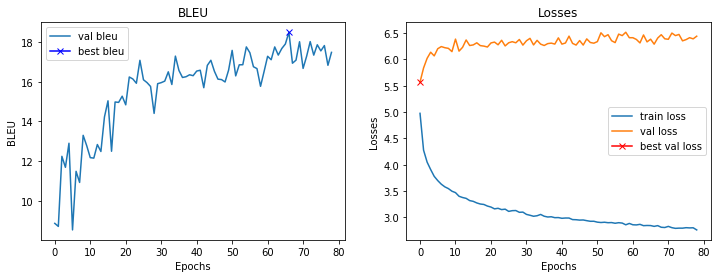

Epoch : 24000
Train example :
	Target: a man and woman wait outside the entrance railing of a subway station outside of a UNK italian restaurant .
	Output: a man in a are for of cafe of . a building . . .
Random example:
	Target: one woman in UNK veil and dress is laughing and conversing with another woman in a white veil and light green dress .
	Output: a woman in a white dress is standing in a group of people .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a yellow shirt is cleaning a pool .
Train loss    : 2.773700459798177
Val loss      : 6.471473127603531
Val bleu      : 17.656683294233062



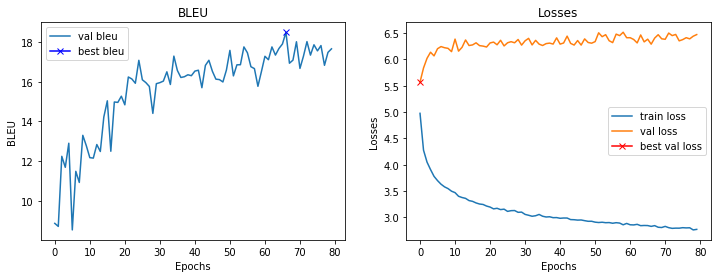

Epoch : 24300
Train example :
	Target: a man stands on a boardwalk with a camera in his hands as a woman in white looks through a telescope over the water towards a large rock outcropping next to a town .
	Output: a woman and on a bench overlooking a body and a head . he woman takes a looks on . bench . the water . him .
Random example:
	Target: a boy wearing a blue shirt is touching the trunk of a tree with his finger .
	Output: a young boy in a blue shirt is climbing a rock .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a yellow shirt is playing with a pool .
Train loss    : 2.7781813208262127
Val loss      : 6.482330709695816
Val bleu      : 17.5010969158516



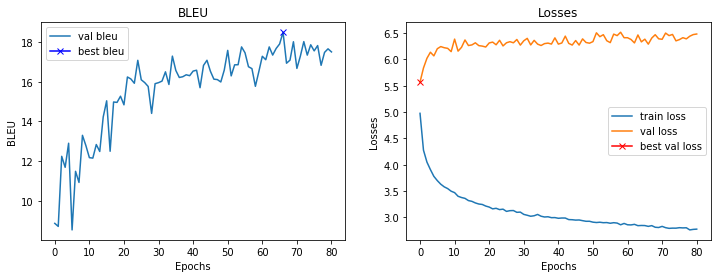

Epoch : 24600
Train example :
	Target: a brown dog is about to catch a treat .
	Output: a brown dog is standing to catch a ball .
Random example:
	Target: a dog licking its lips while snowfalls .
	Output: a dog runs through the snow .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is cleaning the floor of a pool .
Train loss    : 2.78952219804128
Val loss      : 6.2967827171087265
Val bleu      : 18.387980567603652



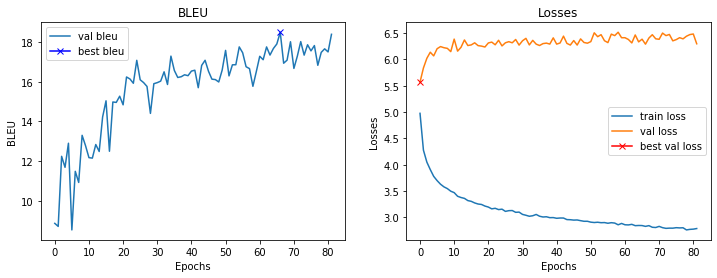

Epoch : 24900
Train example :
	Target: red wall filled with graffiti .
	Output: a construction with with graffiti .
Random example:
	Target: the man on the ground in the blue , white , and red jacket is going something to the bike while the other man standing up in the red , white , and blue outfit holds it up .
	Output: a group of people are riding bikes on a street .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.7649867073694865
Val loss      : 6.385048985481262
Val bleu      : 17.27638551367431



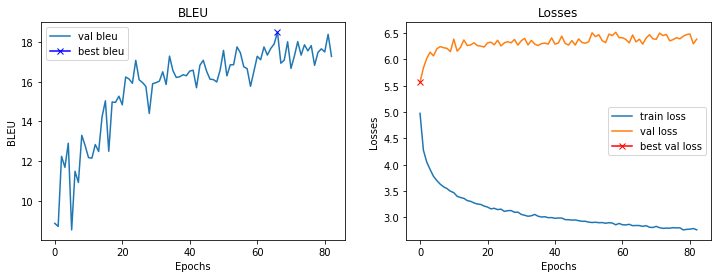

Epoch : 25200
Train example :
	Target: people walking about a university campus with palm trees in the background .
	Output: a are around a park campus . a trees . the background .
Random example:
	Target: a person doing a leap with his bike over a hill
	Output: a man is doing a trick on a skateboard .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.7816599464416503
Val loss      : 6.381051793694496
Val bleu      : 17.617056288101562



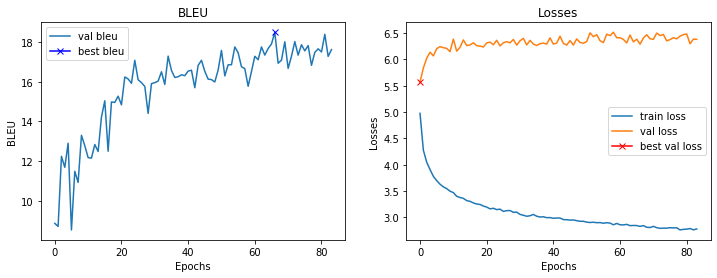

Epoch : 25500
Train example :
	Target: this person is walking down the street and talking on their cellphone on a windy day .
	Output: a woman is taking her child camera with a to her phone . the street . .
Random example:
	Target: a family hiking down the hill on a cloudy day .
	Output: three people are hiking in the mountains .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is standing on a ladder with a man in a blue shirt and blue shorts .
Train loss    : 2.754469449520111
Val loss      : 6.450395151972771
Val bleu      : 16.42042038109194



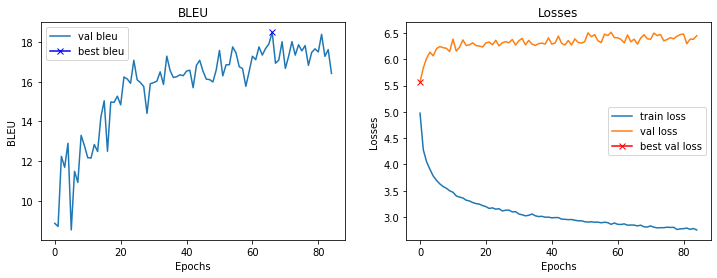

Epoch : 25800
Train example :
	Target: ski equipment sits alone on a snowy mountain
	Output: a equipment in on in a snowy mountain .
Random example:
	Target: people in UNK going on a boat ride .
	Output: a group of people are sitting in a boat .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.758491872946421
Val loss      : 6.437812268733978
Val bleu      : 18.09138749731425



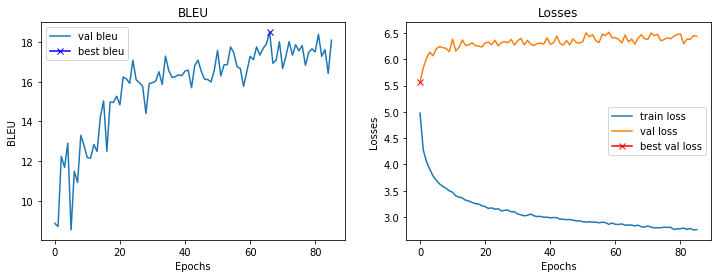

Epoch : 26100
Train example :
	Target: woman in a jacket , walking a small white dog .
	Output: a walking red red walking walking in sidewalk building building .
Random example:
	Target: a young woman wearing white clothing is UNK clothes on a clothesline .
	Output: a man in a blue shirt is holding a hammer .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is cleaning a pool .
Train loss    : 2.7694175545374553
Val loss      : 6.326232835650444
Val bleu      : 17.142281303947065



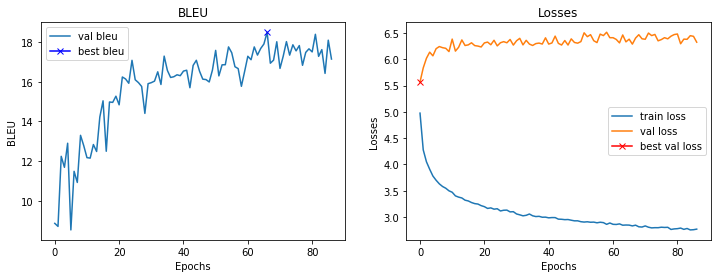

Epoch : 26400
Train example :
	Target: a man plays the bagpipes .
	Output: a man in a black and
Random example:
	Target: a white and brown dog licks his lips during winter .
	Output: a dog is running through the grass .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is playing pool .
Train loss    : 2.7395536430676777
Val loss      : 6.469916939735413
Val bleu      : 17.53130859328109



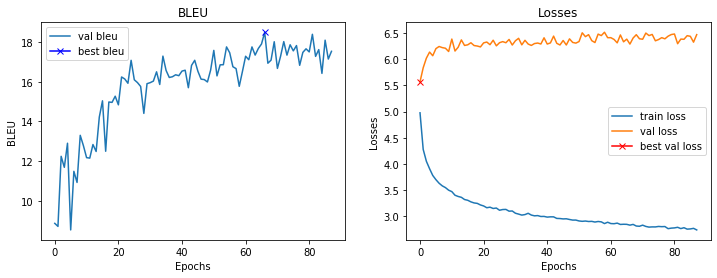

Epoch : 26700
Train example :
	Target: a group of men are gathered in the forest .
	Output: a group of people and women are a woods are
Random example:
	Target: an older fireman with an orange work suit holding a brown water hose .
	Output: a man in a white shirt and a woman in a white shirt are walking down the street .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt is cleaning the water .
Train loss    : 2.7384725689888
Val loss      : 6.449728786945343
Val bleu      : 16.9476838962191



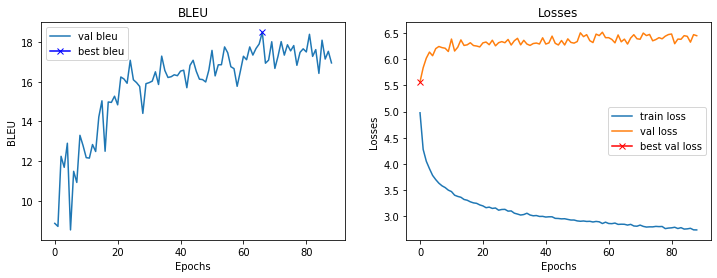

Epoch : 27000
Train example :
	Target: a group of men wait in line to UNK food at a window .
	Output: two group of people are to a to a a UNK . UNK .
Random example:
	Target: a small boy does a handstand on one hand .
	Output: a man in a black shirt and black pants is doing a trick on a skateboard .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is cleaning the pool .
Train loss    : 2.736745822429657
Val loss      : 6.427180036902428
Val bleu      : 16.567068271980453



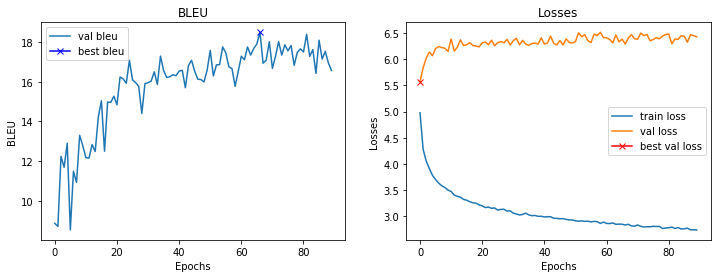

Epoch : 27300
Train example :
	Target: people staring at something in large crowd
	Output: a are at something in the city . people . . . . . . .
Random example:
	Target: a brown and black dog fetching a blue toy .
	Output: a dog running in the snow .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: two men are standing in a pool with a water bottle .
Train loss    : 2.7405650480588277
Val loss      : 6.432390466332436
Val bleu      : 17.014198623310225



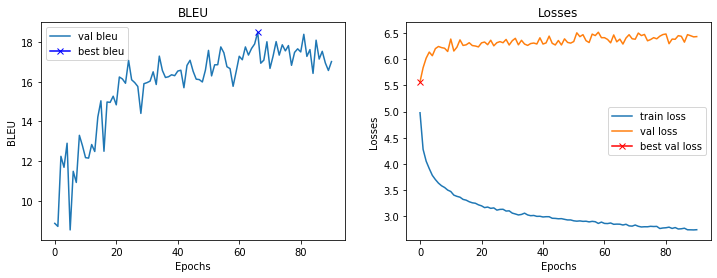

Epoch : 27600
Train example :
	Target: a man practices karate moves in silhouette with a backdrop of a colorful beach sunset .
	Output: a man is a moves on the of a backdrop of a beautiful sunset . .
Random example:
	Target: a construction worker siting on a green tractor .
	Output: a man in a yellow shirt is riding a bicycle on a street .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is playing with a water fountain .
Train loss    : 2.7313281138737997
Val loss      : 6.348862245678902
Val bleu      : 17.96443387550745



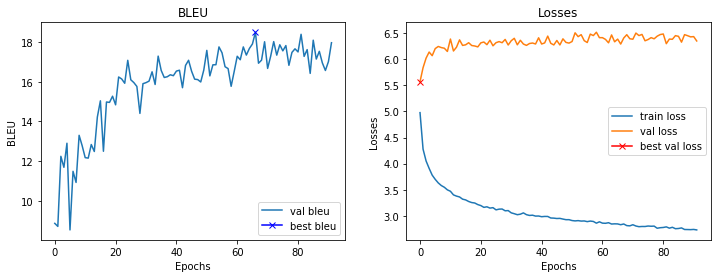

Epoch : 27900
Train example :
	Target: man looks out of second story window .
	Output: a in out of a window window .
Random example:
	Target: a man in a plaid shirt and blue jacket is handing out copies of the " new UNK " .
	Output: a man in a blue shirt and black pants is standing next to a red and white van .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a ladder with a water bottle .
Train loss    : 2.744396011432012
Val loss      : 6.43855744600296
Val bleu      : 17.327786631581084



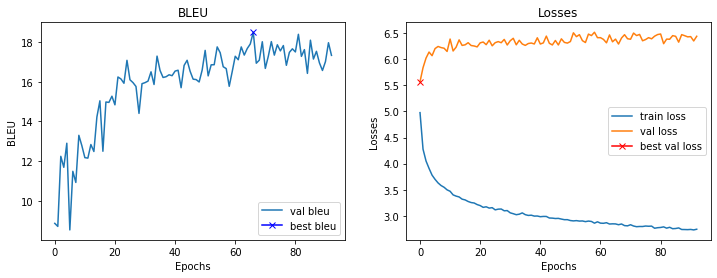

Epoch : 28200
Train example :
	Target: a baseball man playing baseball swings and hits a baseball , while the 4 other men look on .
	Output: a baseball player in baseball . at bat . bat . while a catcher of the watch on .
Random example:
	Target: college students enjoy time out of class in a field .
	Output: a man in a blue shirt is sitting on a beach with a blue ball .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a dock with a water bottle .
Train loss    : 2.7294884165128073
Val loss      : 6.52448482811451
Val bleu      : 17.643362678257358



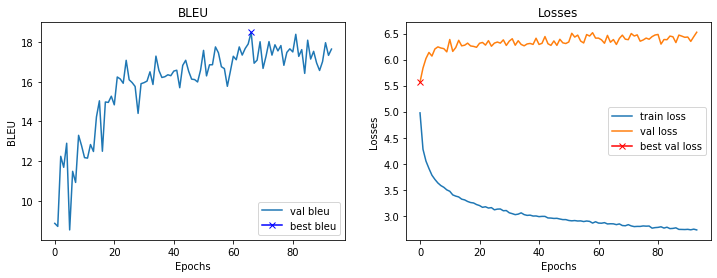

Epoch : 28500
Train example :
	Target: a woman eating food with her hands .
	Output: a man in food in a hands .
Random example:
	Target: a blond girl and brunette girl walking .
	Output: a woman in a black tank top is standing on a sidewalk .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is standing in a pool with a child in a blue shirt .
Train loss    : 2.7331711808840433
Val loss      : 6.541386127471924
Val bleu      : 17.082953314611824



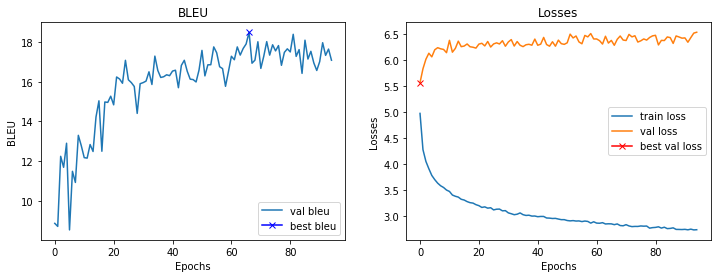

Epoch : 28800
Train example :
	Target: a person on a bike get airborne .
	Output: a man is jumping trick trick jumping .
Random example:
	Target: a man in an orange jacket is snowboarding .
	Output: a man in a red jacket is snowboarding down a mountain .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is playing with a water fountain .
Train loss    : 2.6942640701929728
Val loss      : 6.421500727534294
Val bleu      : 17.755781538056706



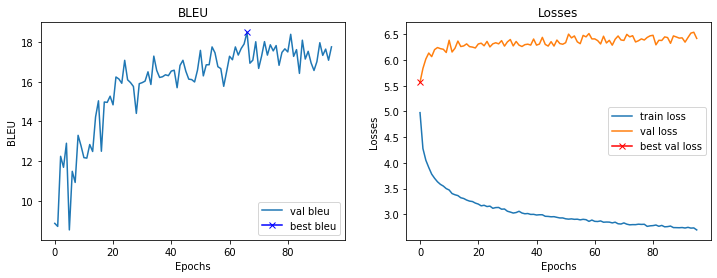

Epoch : 29100
Train example :
	Target: musicians dressed in red and white shirts and khaki pants , performing at a sports arena .
	Output: a in in red and white uniforms are playing pants are and a a concert event .
Random example:
	Target: two ladies are walking across the street laughing .
	Output: a man in a black shirt and black pants is walking down the street with a dog .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a ladder with a child in a blue shirt .
Train loss    : 2.7354077823956806
Val loss      : 6.418067276477814
Val bleu      : 17.34421442153236



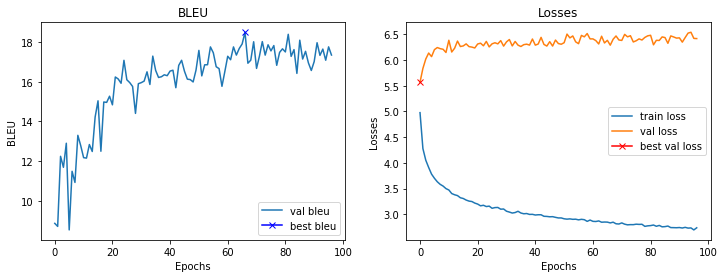

Epoch : 29400
Train example :
	Target: two toddlers , in a stroller , are placed in front of a firetruck .
	Output: a men are riding a red car red on on a of a red .
Random example:
	Target: this is a group of women playing volleyball in sports bikinis .
	Output: a female volleyball player is shooting a ball .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a dock with a hose .
Train loss    : 2.7328650307655336
Val loss      : 6.463713735342026
Val bleu      : 18.041071773582125



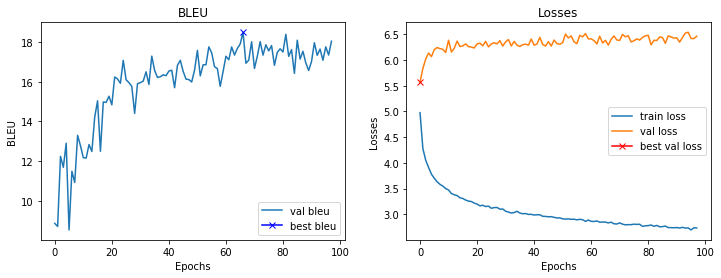

Epoch : 29700
Train example :
	Target: the black dog is walking along a tree trunk bridge over water .
	Output: a dog dog is walking in the river . . . water .
Random example:
	Target: an older woman and a young man play UNK .
	Output: a man in a blue shirt is cutting a cake .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is standing on a ladder with a bucket in his hand .
Train loss    : 2.736536938349406
Val loss      : 6.3996598571538925
Val bleu      : 17.807445133953735



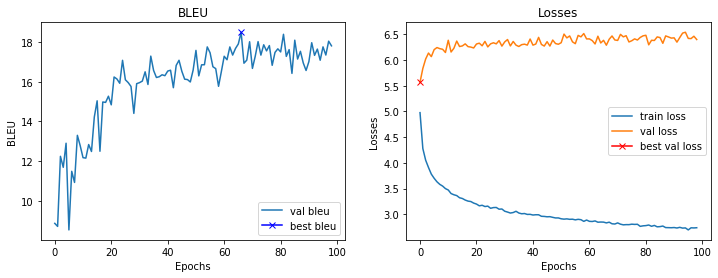

Epoch : 30000
Train example :
	Target: musical band in red light getting ready to perform .
	Output: a band performing a and red ready to perform .
Random example:
	Target: a woman lays her head down on a pillow on a shelf in a store .
	Output: a woman in a white shirt is looking at a book .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is standing on a deck with a blue bucket .
Train loss    : 2.7062640444437664
Val loss      : 6.308798566460609
Val bleu      : 17.78419786103539



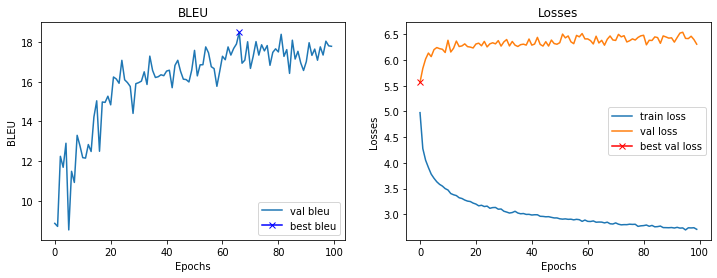

CPU times: user 4h 48min 29s, sys: 34min 30s, total: 5h 23min
Wall time: 4h 42min


In [0]:
%%time
best_bleu = 0
epoch_loss = 0
train_losses = []
val_losses = []
bleu = []
tf = 0.9

for epoch in range(1, max_epochs+1):

  image_vectors, captions_ix = generate_batch(train_dataset, batch_size)
  image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

  captions_ix_next = captions_ix[:, 1:].contiguous()

  network.train()
  network.encoder.eval()

  optimizer.zero_grad()
        
  outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=tf)
 
  loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
        
  loss.backward()
        
  torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
        
  optimizer.step()
        
  epoch_loss += loss.item()

  if epoch % every_epochs == 0:
    print('Epoch : {}'.format(epoch))
    print('Train example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))
    val_loss, val_bleu = evaluate(network, criterion)   
    print('Train loss    : {}'.format(epoch_loss / every_epochs))
    print('Val loss      : {}'.format(val_loss))
    print('Val bleu      : {}'.format(val_bleu))
    print()
    train_losses.append(epoch_loss / every_epochs)
    val_losses.append(val_loss)
    bleu.append(val_bleu)
    if val_bleu > best_bleu:
      best_bleu = val_bleu
      torch.save(network.state_dict(), '/content/drive/My Drive/Image Captioning/Flickr30/3/v6_model_best_bleu.pt')
    epoch_loss = 0
    plot_loss()

In [0]:
torch.save(network.state_dict(), '/content/drive/My Drive/Image Captioning/Flickr30/3/v6_model_30_epoch.pt')

In [0]:
best_bleu

18.491662816457506

# Проверим качество полученной модели

Визуализировать теперь нечего, поэтому просто выведем argmax и несколько сэмплов для каждой картинки.

## Модель с весами после последней эпохи

In [0]:
# network.load_state_dict(torch.load('/content/drive/My Drive/Image Captioning/Flickr30/3/v6_model_30_epoch.pt')) 

<All keys matched successfully>

In [0]:
# network.eval()
# network = network.to(device)

2020-02-20 15:01:10 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


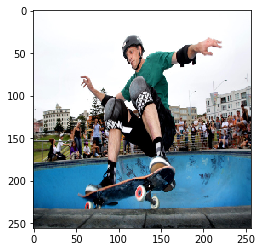

a man in a black shirt and jeans is doing a trick on a skateboard .


In [0]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a man in a black shirt and black pants is doing a trick on a skateboard .
a man wearing a black shirt and jeans is doing a trick on a skateboard .
a man in a black shirt and black pants is jumping over a ramp .
a man in a black shirt and jeans is doing a trick on a skateboard .
a man in a black shirt and jeans is doing a trick on a skateboard .
a man in a black shirt and jeans is doing a trick on a skateboard .
a man in a black shirt and jeans is doing a trick on a skateboard .
a man in a blue shirt and jeans is doing a trick on a skateboard .
a man in a black shirt is doing a trick on a skateboard .
a man in a black shirt and jeans is doing a trick on a skateboard .


2020-02-20 15:02:46 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


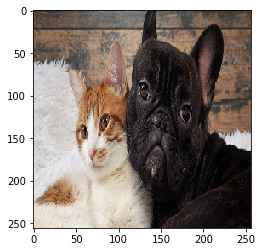

a dog is a cat in its mouth .


In [0]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a dog is laying on its hind legs .
a cat is laying on its hind legs .
a dog is chewing on a bed .
a dog is a cat on the floor .
a dog is a cat on its head .
a dog is laying on its hind legs .
a dog is a cat in its mouth .
a dog is a cat on the floor .
a dog biting a cat .
a dog is a cat on its back .


2020-02-20 15:20:02 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


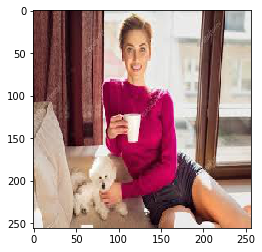

a woman in a pink dress is sitting on a bed .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a young girl in a pink dress is sitting on a bed .
a woman in a red dress and a white dog are sitting on a wooden bench .
a woman in a yellow dress is sitting on a bed .
a woman in a pink dress is sitting on a wooden bench .
a woman in a red dress and a yellow and white striped skirt is sitting on a wooden bench .
a woman in a yellow dress is sitting on a bed with a stuffed animal .
a woman in a pink dress and a pink skirt is sitting on a couch .
a woman in a red dress is sitting on a bed .
a little girl in a pink dress is sitting on a bed .
a woman in a red dress is sitting on a bed with a pink and white dog .


2020-02-20 15:37:50 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


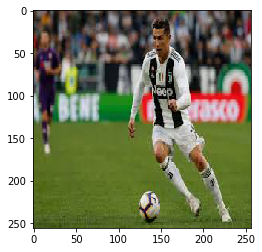

a soccer player in a red uniform is about to kick the ball .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=3)
    print(seq)

a soccer player in the red uniform runs toward the base while the opposing team tries to tackle him .
a man in a red uniform is kicking a soccer ball .
a soccer player in red is about to kick a soccer ball .
a soccer player in a red uniform runs towards the soccer ball .
a soccer player in red is about to kick the ball .
a soccer player in red is about to kick the ball .
a soccer player in a red uniform is running the ball .
a soccer player in a red uniform is about to kick the ball .
a man in a red shirt is running on a soccer field .
a soccer player in a white uniform is about to kick a soccer ball .


2020-02-20 15:44:55 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z [5331/5331] -> "img.jpg" [1]


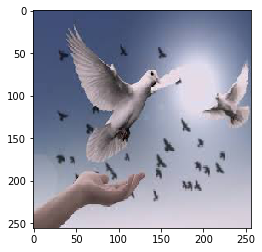

a white bird flies over the water .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a white bird flies over the water .
a white bird flies over the water .
a white bird flies over the water .
a white bird flies over the air .
a white bird flies over the water .
a white bird is flying over the water .
a person is jumping into the air .
a white bird flies over the water .
a person is flying over the air .
a man is flying over a large body of water .


2020-02-20 15:48:05 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK [9963/9963] -> "img.jpg" [1]


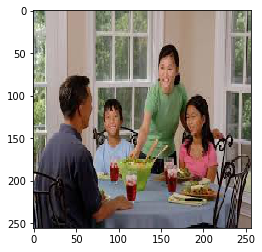

two women and two women are sitting at a table with a beer .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=3)
    print(seq)

a group of people are sitting around a table with drinks .
two women and two men are sitting at a table and drinking beer .
a group of people are sitting at a table with drinks .
two women are sitting at a table with a beer .
two women are sitting at a table with a man in a green shirt .
three women are sitting at a table with a green tablecloth .
a group of people sitting at a table with a meal .
three women are sitting at a table with a beer .
a group of people are sitting at a table with a beer .
three women are sitting at a table eating food .


## Модель с best BLEU

In [0]:
network.load_state_dict(torch.load('/content/drive/My Drive/Image Captioning/Flickr30/3/v6_model_best_bleu.pt')) 

<All keys matched successfully>

In [0]:
network.eval()
network = network.to(device)

2020-02-20 15:54:12 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


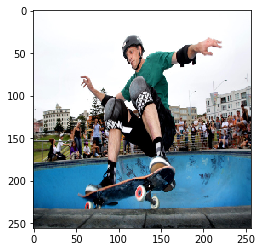

a man in a black shirt is doing a trick on a skateboard .


In [0]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=5, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a young man is doing a trick on a skateboard .
a man in a black shirt is doing a trick on a skateboard .
a man in a black shirt and black shorts is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man in a black shirt is doing a trick on a skateboard .
a man in a black shirt is doing a trick on a skateboard .
a young man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .


2020-02-20 15:54:40 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


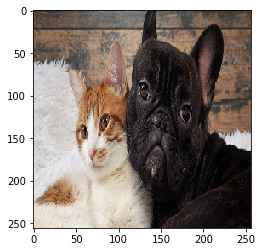

a dog is laying on the bed .


In [0]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=3, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a dog is laying on the bed .
a dog is laying on the bed .
a cat is laying on the bed .
a cat is laying on the bed with a stuffed animal .
a cat is laying on the bed .
a cat is laying on the bed with a stuffed animal .
a dog is laying on the bed .
a dog is a cat in a room .
a dog is laying on a bed .
a dog is laying on the bed .


2020-02-20 15:55:06 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


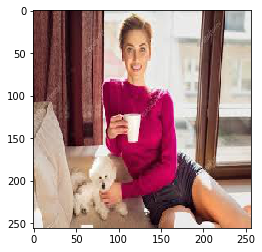

a little girl in a pink dress is sitting on a couch .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=3, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=4)
    print(seq)

a little girl in a pink dress is sitting on a couch .
a woman in a red shirt is sitting on a couch .
a little girl in a pink dress is sitting on a couch .
a little girl is sitting on a couch and a white dog .
a little girl in a pink shirt is sitting on the couch .
a little girl in a pink dress is sitting on a couch .
a young girl in a pink dress is sitting on a bed .
a little girl is sitting on the couch and a white dog .
a little girl is sitting on a couch .
a little girl is sitting on a couch .


2020-02-20 16:06:39 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


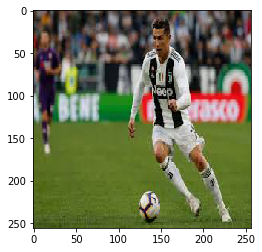

a soccer player in a red uniform is attempting to throw a ball .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=3, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=4)
    print(seq)

a soccer player in a white uniform is about to throw a ball .
a soccer player in a red uniform is attempting to throw the ball .
a soccer player is attempting to get the ball .
a soccer player in a red uniform is attempting to hit the ball .
a soccer player in a red uniform is attempting to throw the ball .
a soccer player in a red uniform is attempting to throw the ball .
a man in a white uniform is playing soccer .
a soccer player in a white uniform is attempting to throw a soccer ball .
a soccer player in a red uniform is attempting to throw the ball .
a soccer player in a red uniform is getting ready to throw a ball .


2020-02-20 16:16:55 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z [5331/5331] -> "img.jpg" [1]


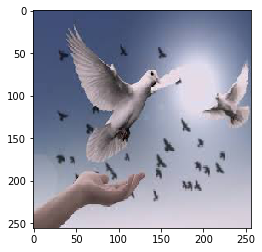

a white bird flies into the air .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=3, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

a white bird flies into the air .
a white bird is flying over the air .
a white bird flies over the air .
a white bird flies into the air .
a white bird flies above the air .
a white bird is flying over the air .
a white bird is flying above the air .
a white bird flies into the air .
a white bird flies over the air .
a white bird flies into the air .


2020-02-20 16:19:38 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK [9963/9963] -> "img.jpg" [1]


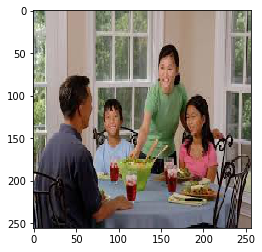

two women are sitting at a table with a drink .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((256, 256))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32) 
img = image_transform(img).unsqueeze(0).to(device)

seq = network.sample(img, st=3, sample=False)
print(seq)

In [0]:
for i in range(10):
    seq = network.sample(img, st=5)
    print(seq)

two women are sitting at a table with a drink and drink .
three people are sitting around a table with a green tablecloth .
a group of people are sitting around a table with a drink .
three people are sitting at a table with a laptop .
a group of people are sitting around a table with a green tablecloth .
three people are sitting around a table with a drink .
a group of people are sitting at a table with a green tablecloth .
a group of people are sitting around a table with a green tablecloth .
a group of people are sitting around a table with a beer .
a group of people are sitting at a table with a drink .
